# Flood Prediction

Alicia Bayerl, Rosanna Beckmann, Tim Kapferer, Michael Ramich, Hendrik Schmidt, Maximilian Springer

---

This is our final project for the course Neurodynamics hold at the University of Osnabrück in the summer term 2022. 

**Please make sure to copy the [data](https://drive.google.com/drive/folders/1vs0Wwpi-SQr0MIJ0y1A-rSjI7lIsLIWc) to your Google Drive to be able to excute this notebook.**

This notebook includes the **hourly** predictions.

## Contents

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
from IPython.display import Image

# Data

We use weather data from the [Deutscher Wetterdienst (DWD)](https://www.dwd.de/DE/leistungen/klimadatendeutschland/klimadatendeutschland.html) and the water level from multiple locations in and around Hamburg provided by the Hamburg Port Authority (HPA). 

## Weather Data


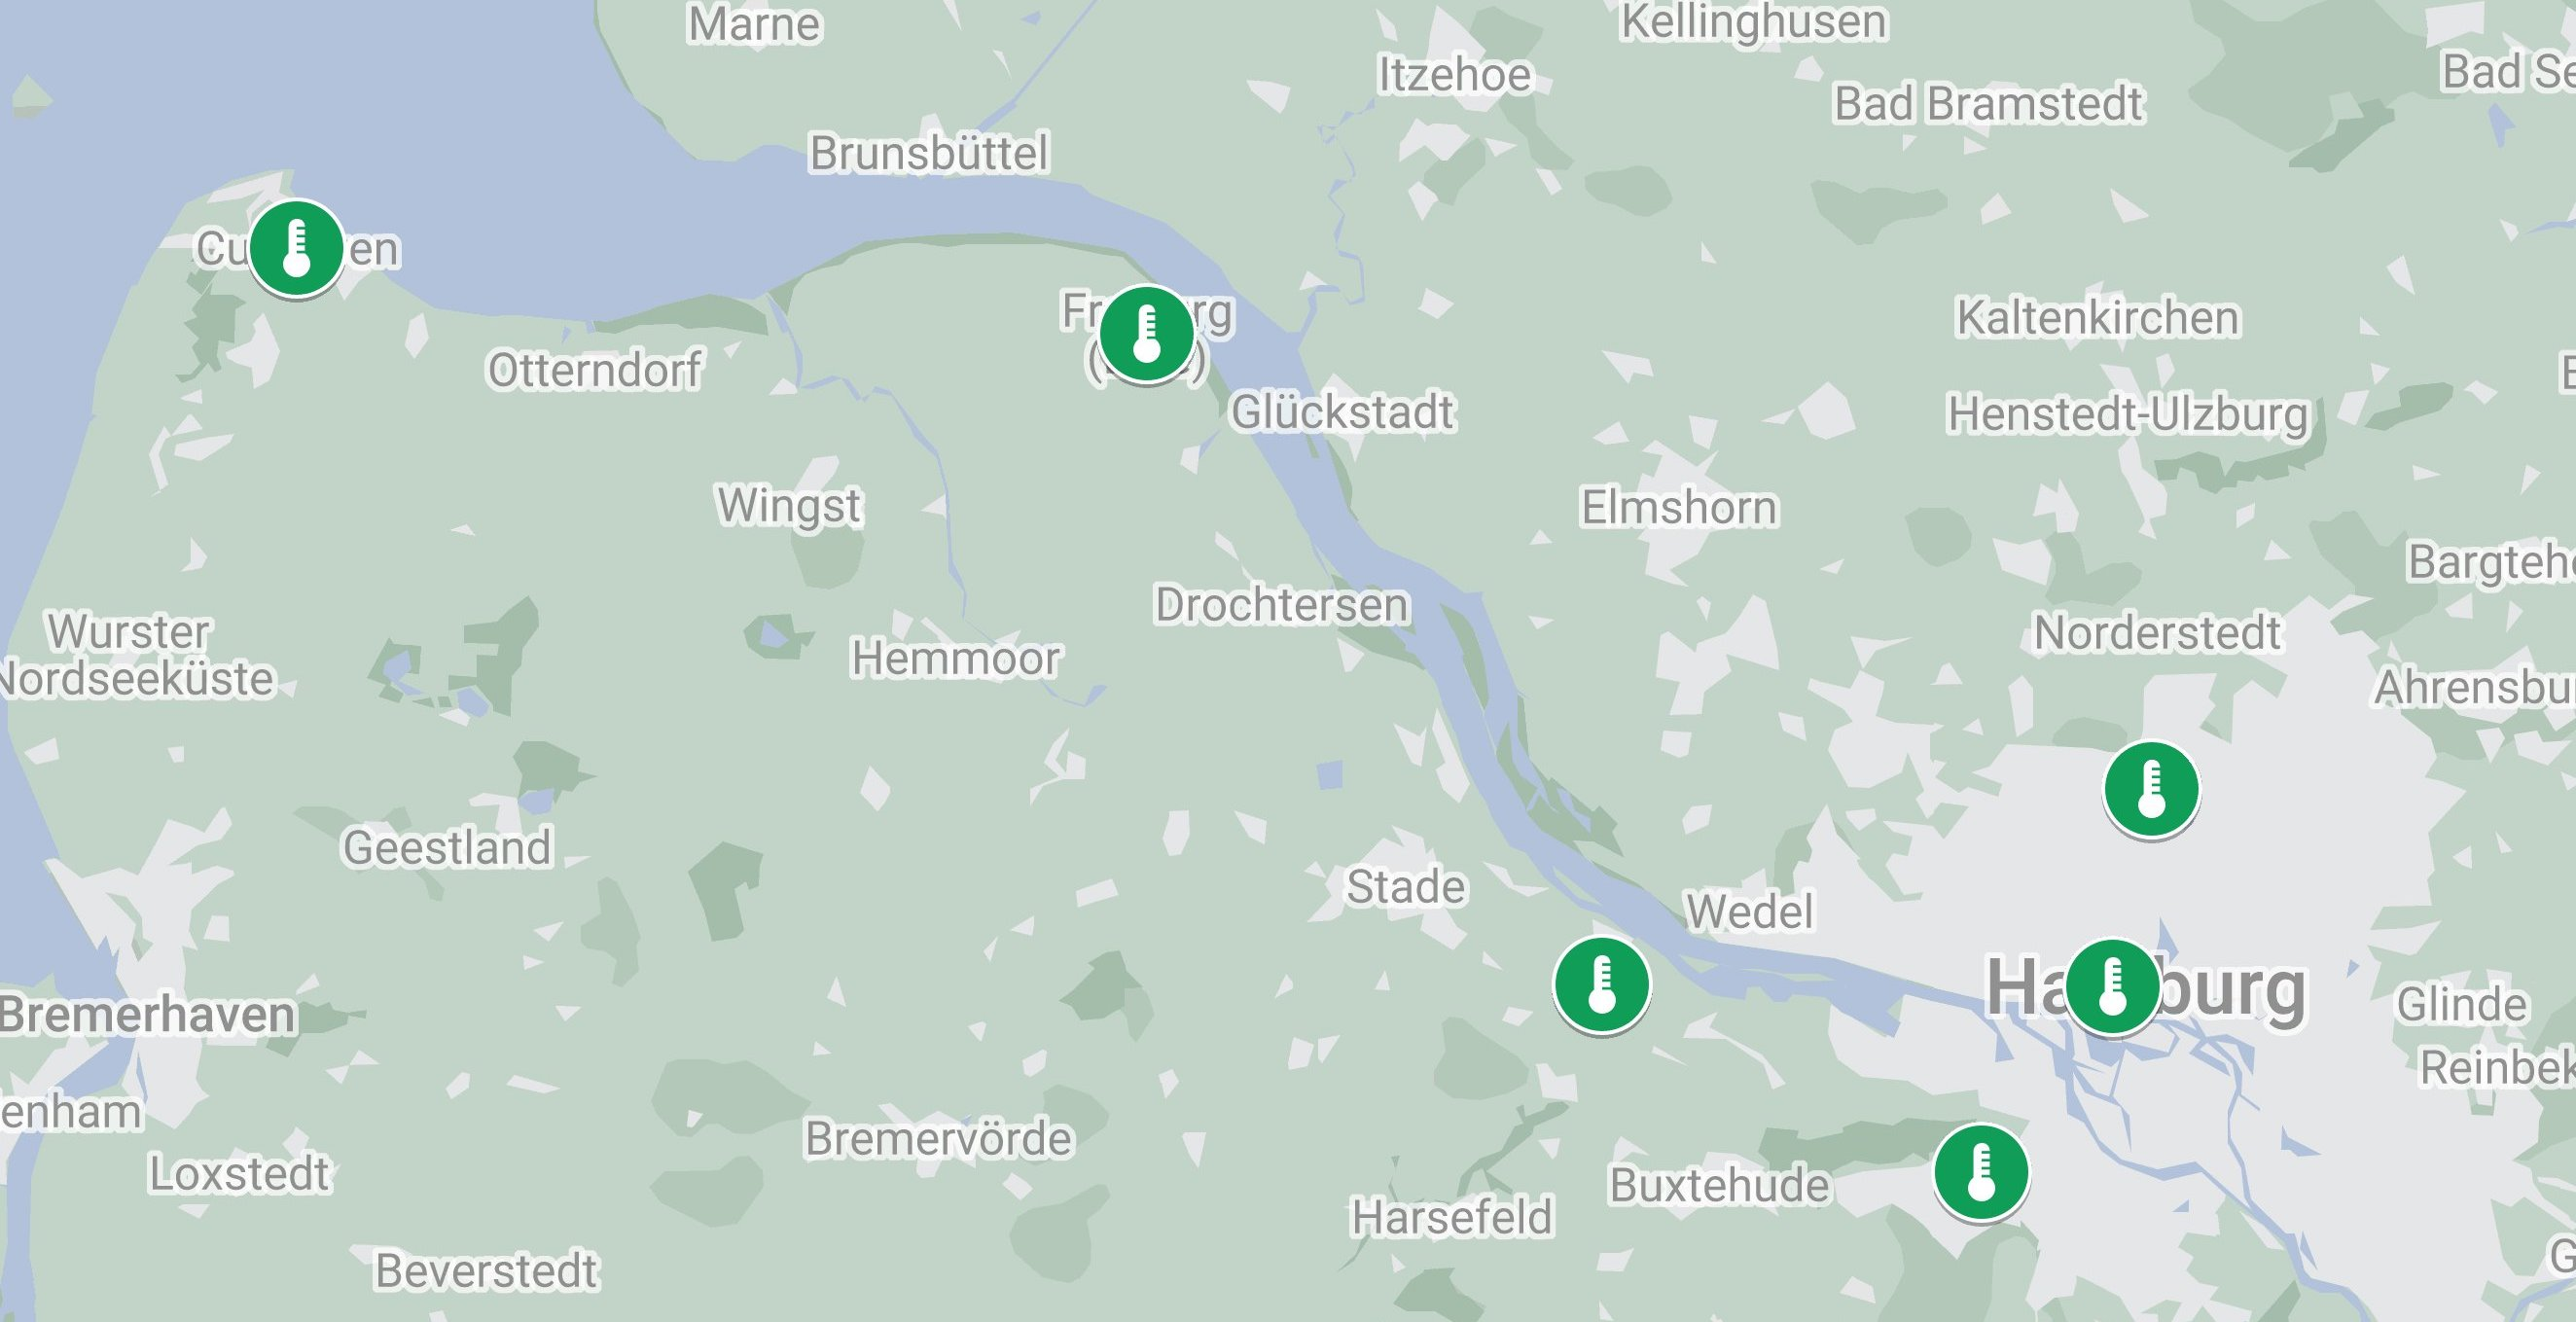

In [ ]:
Image('/content/gdrive/MyDrive/Neurodynamics Group2/Images/mapimage.jpeg', width=600)

### Hamburg Flughafen

In [ ]:
def read_csv_weather(file):
    df = pd.read_csv(file, delimiter=';')
    df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format="%Y%m%d%H")
    df.set_index('MESS_DATUM', inplace=True)
    df = df['2000-01-01':'2020-12-31']
    timestamp_s = df.index.map(pd.Timestamp.timestamp)
    df.reset_index(inplace=True)
    df = df.replace(-999, pd.NA)
    
    return df

**R1** : Niederschlagshoehe (mm)
<br>
**RS_IND** : Indikator Niedersschlag ja/nein (numerischer Code)
<br>
**WRTR** : stdl. Niederschlagsform (=Niederschlagshoehe_ind) (numerischer Code)

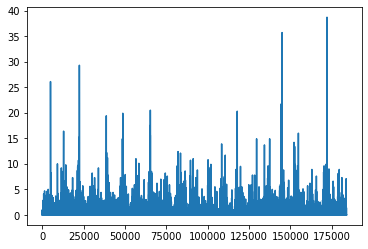

In [ ]:
hamburg_airport_rr = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Hamburg Flughafen/stundenwerte_RR_01975_19950905_20211231_hist/produkt_rr_stunde_19950905_20211231_01975.txt')
hamburg_airport_rr['  R1'] = pd.to_numeric(hamburg_airport_rr['  R1'], errors='coerce')
hamburg_airport_rr['  R1'].plot()
hamburg_airport_rr.drop(hamburg_airport_rr.columns[[1,2,4,5,6]], inplace=True, axis=1)

**ABSF_STD** : berechnete Stundenwerte der absoluten Feuchte (%%) <br>
**VP_STD** : berechnete Stundenwerte des Dampfdruckes (hpa) <br>
**TF_STD** : berechnete Stundenwerte der Feuchttemperatur (C) <br>
**TT_STD**: Lufttemperatur (2m Hoehe) (C) <br>
**P_STD** : Stundenwerte Luftdruck (hpa)<br>
**RF_STD** : Stundenwerte der Relativen Feuchte (%) <br>
**TD_STD**: Taupunkttemperatur (2m hoehe) (C)

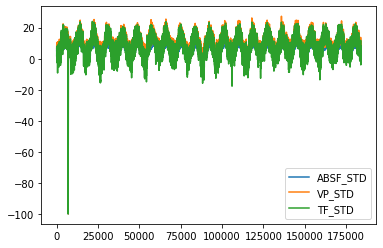

In [ ]:
hamburg_airport_tf = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Hamburg Flughafen/stundenwerte_TF_01975_19490101_20211231_hist/produkt_tf_stunde_19490101_20211231_01975.txt')
hamburg_airport_tf[['ABSF_STD','VP_STD','TF_STD']].plot()
hamburg_airport_tf.drop(hamburg_airport_tf.columns[[1,2,10]], inplace=True, axis=1)

**RF_TU**: Relative Feuchte (%)<br>
**TT_TU**: Lufttemperatur (C)<br>

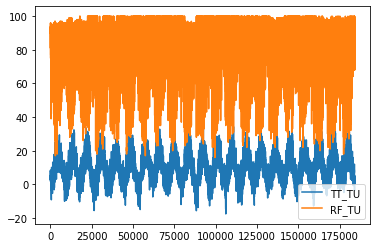

In [ ]:
hamburg_airport_tu = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Hamburg Flughafen/stundenwerte_TU_01975_19490101_20211231_hist/produkt_tu_stunde_19490101_20211231_01975.txt')
hamburg_airport_tu['TT_TU'] = pd.to_numeric(hamburg_airport_tu['TT_TU'], errors='coerce')
hamburg_airport_tu['RF_TU'] = pd.to_numeric(hamburg_airport_tu['RF_TU'], errors='coerce')
hamburg_airport_tu[hamburg_airport_tu.columns[[3,4]]].plot()
hamburg_airport_tu.drop(hamburg_airport_tu.columns[[1,2,5]], inplace=True, axis=1)

**P**: auf NN reduzierter Luftdruck <br>
**P0** Luftdruck in Stationhoehe

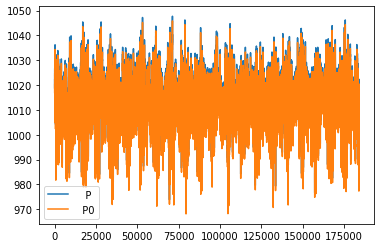

In [ ]:
hamburg_airport_po = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Hamburg Flughafen/stundenwerte_P0_01975_19490101_20211231_hist/produkt_p0_stunde_19490101_20211231_01975.txt')
hamburg_airport_po['   P'] = pd.to_numeric(hamburg_airport_po['   P'], errors='coerce')
hamburg_airport_po['  P0'] = pd.to_numeric(hamburg_airport_po['  P0'], errors='coerce')
hamburg_airport_po[['   P','  P0']].plot()
hamburg_airport_po.drop(hamburg_airport_po.columns[[1,2,4,5]], inplace=True, axis=1)

**F**
: Windgeschwindigkeit (m/sec) <br>
**D**
: Windrichtung (Grad)

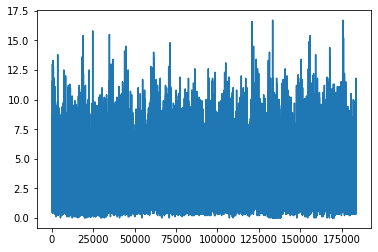

In [ ]:
hamburg_airport_ff = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Hamburg Flughafen/stundenwerte_FF_01975_19500101_20211231_hist/produkt_ff_stunde_19500101_20211231_01975.txt')
hamburg_airport_ff['   F'] = pd.to_numeric(hamburg_airport_ff['   F'], errors='coerce')
hamburg_airport_ff['   D'] = pd.to_numeric(hamburg_airport_ff['   D'], errors='coerce')
hamburg_airport_ff = hamburg_airport_ff.replace(-999, np.nan)
hamburg_airport_ff['   F'].plot()
hamburg_airport_ff.drop(hamburg_airport_ff.columns[[1,2,5]], inplace=True, axis=1)

In [ ]:
# Combining the dataframes 
full_hamburg_airport = pd.merge(hamburg_airport_ff, hamburg_airport_tu, how="inner", on='MESS_DATUM')
full_hamburg_airport = pd.merge(full_hamburg_airport, hamburg_airport_rr, how="inner", on='MESS_DATUM')
full_hamburg_airport = pd.merge(full_hamburg_airport, hamburg_airport_po, how="inner", on='MESS_DATUM')

# Fill na values with the mean value 
full_hamburg_airport = full_hamburg_airport.fillna(full_hamburg_airport.mean(numeric_only=True))

# Represent the wind velocity and wind direction to enhance interpretability
wv = full_hamburg_airport['   F']

# Convert to radians.
wd_rad = full_hamburg_airport['   D']*np.pi / 180

# Calculate the wind x and y components.
full_hamburg_airport['Wx'] = wv*np.cos(wd_rad)
full_hamburg_airport['Wy'] = wv*np.sin(wd_rad)

full_hamburg_airport.drop(full_hamburg_airport.columns[[1,2]], inplace=True, axis=1)

In [ ]:
full_hamburg_airport

,MESS_DATUM,TT_TU,RF_TU,R1,P,Wx,Wy
0,2000-01-01 00:00:00,2.8,90.0,0.0,1022.1,-2.349232,0.855050
1,2000-01-01 01:00:00,2.8,90.0,0.0,1022.0,-2.560500,0.451485
2,2000-01-01 02:00:00,3.1,90.0,0.0,1021.7,-2.631139,0.957656
3,2000-01-01 03:00:00,3.0,90.0,0.0,1021.4,-2.725109,0.991858
4,2000-01-01 04:00:00,3.3,90.0,0.0,1020.9,-3.100986,-1.128666
...,...,...,...,...,...,...,...
183612,2020-12-31 19:00:00,3.3,84.0,0.0,1003.1,-3.290897,-1.900000
183613,2020-12-31 20:00:00,3.2,85.0,0.0,1003.4,-3.637307,-2.100000
183614,2020-12-31 21:00:00,3.3,85.0,0.0,1003.7,-3.643789,-0.642498
183615,2020-12-31 22:00:00,3.0,89.0,0.0,1004.0,-3.476863,-1.265475


### Cuxhaven, Helgoland, Mittelnkirchen-Hohenfelde and Hamburg Neuwiedenthal



**Cuxhaven**

In [ ]:
cuxhaven_ff = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Cuxhaven/stundenwerte_FF_00891_19690101_20211231_hist/produkt_ff_stunde_19690101_20211231_00891.txt')
cuxhaven_ff.drop(cuxhaven_ff.columns[[1,2,5]], inplace=True, axis=1)

cuxhaven_rr = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Cuxhaven/stundenwerte_RR_00891_20000510_20211231_hist/produkt_rr_stunde_20000510_20211231_00891.txt')
cuxhaven_rr.drop(cuxhaven_rr.columns[[1,2,4,5,6]], inplace=True, axis=1)

cuxhaven_tf = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Cuxhaven/stundenwerte_TF_00891_19490101_20211231_hist/produkt_tf_stunde_19490101_20211231_00891.txt')
cuxhaven_tf.drop(cuxhaven_tf.columns[[1,2,10]], inplace=True, axis=1)

cuxhaven_po = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Cuxhaven/stundenwerte_P0_00891_19490101_20211231_hist/produkt_p0_stunde_19490101_20211231_00891.txt')
cuxhaven_po.drop(cuxhaven_po.columns[[1,2,4]], inplace=True, axis=1)

# Combining the datasets
full_cuxhaven = pd.merge(cuxhaven_ff, cuxhaven_po, how="inner", on='MESS_DATUM')
full_cuxhaven = pd.merge(full_cuxhaven, cuxhaven_rr, how="inner", on='MESS_DATUM')

full_cuxhaven = full_cuxhaven.fillna(full_cuxhaven.mean())

wv = full_cuxhaven['   F']

# Convert to radians.
wd_rad = full_cuxhaven['   D']*np.pi / 180

# Calculate the wind x and y components.
full_cuxhaven['Wx'] = wv*np.cos(wd_rad)
full_cuxhaven['Wy'] = wv*np.sin(wd_rad)

full_cuxhaven.drop(full_cuxhaven.columns[[1,2,4]], inplace=True, axis=1)
full_cuxhaven

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,MESS_DATUM,P,R1,Wx,Wy
0,2000-05-10 12:00:00,1018.9,0.0,1.732051,-1.000000
1,2000-05-10 13:00:00,1018.8,0.0,2.857884,-1.650000
2,2000-05-10 14:00:00,1018.5,0.0,3.906827,-3.278217
3,2000-05-10 15:00:00,1018.3,0.0,3.906827,-3.278217
4,2000-05-10 16:00:00,1018.2,0.0,4.936345,-2.850000
...,...,...,...,...,...
179882,2020-12-31 19:00:00,1002.1,0.3,-3.983717,-2.300000
179883,2020-12-31 20:00:00,1002.4,0.0,-3.523804,-2.956823
179884,2020-12-31 21:00:00,1002.8,0.0,-3.217387,-2.699708
179885,2020-12-31 22:00:00,1003.2,0.0,-2.378314,-2.834364


**Helgoland**

In [ ]:
helgoland_ff = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Helgoland/stundenwerte_FF_02115_19590101_20211231_hist/produkt_ff_stunde_19590101_20211231_02115.txt')
helgoland_ff.drop(helgoland_ff.columns[[1,2,5]], inplace=True, axis=1)

helgoland_po = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Helgoland/stundenwerte_P0_02115_19520301_20211231_hist/produkt_p0_stunde_19520301_20211231_02115.txt')
helgoland_po.drop(helgoland_po.columns[[1,2,4]], inplace=True, axis=1)

full_helgo = pd.merge(helgoland_ff, helgoland_po, how="inner", on='MESS_DATUM')
full_helgo = full_helgo.fillna(full_helgo.mean())

wv = full_helgo['   F']

# Convert to radians.
wd_rad = full_helgo['   D']*np.pi / 180

# Calculate the wind x and y components.
full_helgo['Wx'] = wv*np.cos(wd_rad)
full_helgo['Wy'] = wv*np.sin(wd_rad)

full_helgo.drop(full_helgo.columns[[1,2,4]], inplace=True, axis=1)
full_helgo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,MESS_DATUM,P,Wx,Wy
0,2000-01-01 00:00:00,1020.1,-7.976943,-1.406550e+00
1,2000-01-01 01:00:00,1019.8,-8.739141,-3.180787e+00
2,2000-01-01 02:00:00,1019.8,-8.746857,-5.050000e+00
3,2000-01-01 03:00:00,1019.1,-9.115018,-3.317595e+00
4,2000-01-01 04:00:00,1018.9,-7.966862,-6.684991e+00
...,...,...,...,...
182770,2020-12-31 19:00:00,1001.2,-0.503580,-2.855942e+00
182771,2020-12-31 20:00:00,1001.7,2.681156,-2.249757e+00
182772,2020-12-31 21:00:00,1002.3,2.144924,-1.799805e+00
182773,2020-12-31 22:00:00,1002.6,4.100000,-1.004210e-15


**Mittelnkirchen-Hohenfelde**

In [ ]:
mitt_hohen_rr = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Mittelnkirchen-Hohenfelde/stundenwerte_RR_04857_20040901_20211231_hist/produkt_rr_stunde_20040901_20211231_04857.txt')
mitt_hohen_rr.drop(mitt_hohen_rr.columns[[1,2,4,5,6]], inplace=True, axis=1)

mitt_hohen_tu = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Mittelnkirchen-Hohenfelde/stundenwerte_TU_04857_20040901_20211231_hist/produkt_tu_stunde_20040901_20211231_04857.txt')
mitt_hohen_tu.drop(mitt_hohen_tu.columns[[1,2,5]], inplace=True, axis=1)

full_mitt_hohen = pd.merge(mitt_hohen_rr, mitt_hohen_tu, how="inner", on='MESS_DATUM')

full_mitt_hohen = full_mitt_hohen.fillna(full_mitt_hohen.mean())
full_mitt_hohen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  if __name__ == '__main__':


,MESS_DATUM,R1,TT_TU,RF_TU
0,2004-09-01 00:00:00,0.1,12.6,91.0
1,2004-09-01 01:00:00,0.0,12.6,90.0
2,2004-09-01 02:00:00,0.0,12.4,90.0
3,2004-09-01 03:00:00,0.0,12.5,88.0
4,2004-09-01 04:00:00,0.0,12.5,86.0
...,...,...,...,...
135461,2020-12-31 19:00:00,0.0,2.5,90.0
135462,2020-12-31 20:00:00,0.0,2.1,90.0
135463,2020-12-31 21:00:00,0.0,2.4,91.0
135464,2020-12-31 22:00:00,0.0,2.7,91.0


**Hamburg Neuwiedenthal**

In [ ]:
hamburg_neuwied_rr = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Hamburg-Neuwiedenthal/stundenwerte_RR_01981_20050301_20211231_hist/produkt_rr_stunde_20050301_20211231_01981.txt')
hamburg_neuwied_rr.drop(hamburg_neuwied_rr.columns[[1,2,4,5,6]], inplace=True, axis=1)

hamburg_neuwied_tu = read_csv_weather('/content/gdrive/MyDrive/Neurodynamics Group2/Climate Data/Hamburg-Neuwiedenthal/stundenwerte_TU_01981_20050301_20211231_hist/produkt_tu_stunde_20050301_20211231_01981.txt')
hamburg_neuwied_tu.drop(hamburg_neuwied_tu.columns[[1,2,5]], inplace=True, axis=1)

full_hamburg_neuwied = pd.merge(hamburg_neuwied_rr, hamburg_neuwied_tu, how="inner", on='MESS_DATUM')
full_hamburg_neuwied = full_hamburg_neuwied.fillna(full_hamburg_neuwied.mean())
full_hamburg_neuwied 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,MESS_DATUM,R1,TT_TU,RF_TU
0,2005-03-01 00:00:00,0.0,-1.6,55.0
1,2005-03-01 01:00:00,0.0,-2.0,56.0
2,2005-03-01 02:00:00,0.0,-2.8,58.0
3,2005-03-01 03:00:00,0.0,-3.1,60.0
4,2005-03-01 04:00:00,0.0,-3.1,61.0
...,...,...,...,...
138763,2020-12-31 19:00:00,0.0,3.4,88.0
138764,2020-12-31 20:00:00,0.0,2.2,92.0
138765,2020-12-31 21:00:00,0.0,2.7,90.0
138766,2020-12-31 22:00:00,0.0,3.0,90.0


### Combining the location

In [ ]:
full_weather = pd.merge(full_cuxhaven, full_hamburg_airport, how="inner", on='MESS_DATUM')
full_weather = pd.merge(full_weather, full_hamburg_neuwied, how="inner", on='MESS_DATUM')
full_weather = pd.merge(full_weather, full_helgo, how="inner", on='MESS_DATUM')
full_weather = pd.merge(full_weather, full_mitt_hohen, how="inner", on='MESS_DATUM')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'  R1_x'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.


In [ ]:
full_weather.head()

,MESS_DATUM,P_x,R1_x,Wx_x,Wy_x,TT_TU_x,RF_TU_x,R1_y,P_y,Wx_y,Wy_y,R1_x,TT_TU_y,RF_TU_y,P,Wx,Wy,R1_y,TT_TU,RF_TU
0,2005-03-01 00:00:00,1009.3,0.0,-6.128356,-5.142301,-2.0,59.0,0.0,1010.8,-3.700000,-6.408588,0.0,-1.6,55.0,1007.6,-10.927389,-13.022756,0.0,-2.0,60.0
1,2005-03-01 01:00:00,1008.2,0.0,-5.668729,-4.756628,-2.5,56.0,0.0,1010.0,-3.850000,-6.668396,0.0,-2.0,56.0,1006.6,-13.788800,-11.570177,0.0,-2.4,59.0
2,2005-03-01 02:00:00,1007.2,0.0,-5.975147,-5.013743,-3.0,62.0,0.0,1008.9,-4.949465,-5.898542,0.0,-2.8,58.0,1005.3,-14.248427,-11.955850,0.0,-2.5,60.0
3,2005-03-01 03:00:00,1006.1,0.0,-6.928203,-4.000000,-3.4,65.0,0.0,1007.9,-5.821938,-4.885186,0.0,-3.1,60.0,1004.5,-14.478240,-12.148686,0.0,-2.7,63.0
4,2005-03-01 04:00:00,1005.1,0.3,-6.894400,-5.785088,-3.4,67.0,0.0,1006.8,-6.511378,-5.463695,0.0,-3.1,61.0,1004.0,-13.558987,-11.377341,0.0,-2.6,65.0


## Water Data

In [ ]:
stpauli_minute = pd.read_csv('/content/gdrive/MyDrive/Neurodynamics Group2/Pegel und Tidescheitel/St. Pauli/Hourly Waterlevel/Pegel_STP_01-01-2000-00-00_31-12-2021-00-00.csv', delimiter=';')

# Fill missing values with the mean 
waterlevel_mean = stpauli_minute['Wasserstand (Ganglinie) [cm]'].dropna().mean()
stpauli_minute['Wasserstand (Ganglinie) [cm]'].fillna(value=waterlevel_mean, inplace=True)

# Rename the columns  
stpauli_minute.rename(columns={'Datum/Uhrzeit': 'date', 'Wasserstand (Ganglinie) [cm]': 'waterlevel'}, errors="raise", inplace=True)

stpauli_minute['date'] = pd.to_datetime(stpauli_minute['date'], format="%Y.%m.%d %H:%M:%S")
stpauli_minute.set_index('date', inplace=True)
stpauli_minute['waterlevel'] = stpauli_minute['waterlevel'].astype('float32')

# Take the minute for which the water level was hightest 
stpauli_hourly = stpauli_minute.resample('H').max()
stpauli_hourly['waterlevel'].fillna(value=waterlevel_mean, inplace=True)

timestamp_s = stpauli_hourly.index.map(pd.Timestamp.timestamp)

# Since the sea level (Normalnull) for Hamburg changed 
conditions = [
    stpauli_hourly['Bezugshorizont'].eq('DHHN92'),
    stpauli_hourly['Bezugshorizont'].eq('DHHN2016')
]

choices = [500,500.4]

stpauli_hourly['waterlevel'] = stpauli_hourly['waterlevel'] + np.select(conditions, choices, default=0)

stpauli_hourly.drop(stpauli_hourly.columns[[1,2]], inplace=True, axis=1)
stpauli_hourly = stpauli_hourly.astype('float32')

# Delete the values from the year 2015, as many values were missing 
stpauli_hourly = stpauli_hourly.drop(pd.date_range('2015-01-01 00:00:00', '2015-12-31 00:00:00'), errors='ignore')

# the value on the 8.8.2014 at 10 was faulty, it is thus replaced with the highest valeu from that day
stpauli_hourly.loc['2014-08-08 10:00:00', 'waterlevel'] = 701

stpauli_hourly.head(-5)

,waterlevel
date,
2000-01-01 00:00:00,655.0
2000-01-01 01:00:00,609.0
2000-01-01 02:00:00,537.0
2000-01-01 03:00:00,474.0
2000-01-01 04:00:00,424.0
...,...
2021-12-30 15:00:00,572.0
2021-12-30 16:00:00,504.0
2021-12-30 17:00:00,451.0


The values for the severeness of the flood were taken from this [pdf](https://www.hamburg.de/contentblob/12075018/20021069b46b1ba6a14f3165c04ff64c/data/d-sturmflutposter-bue.pdf).

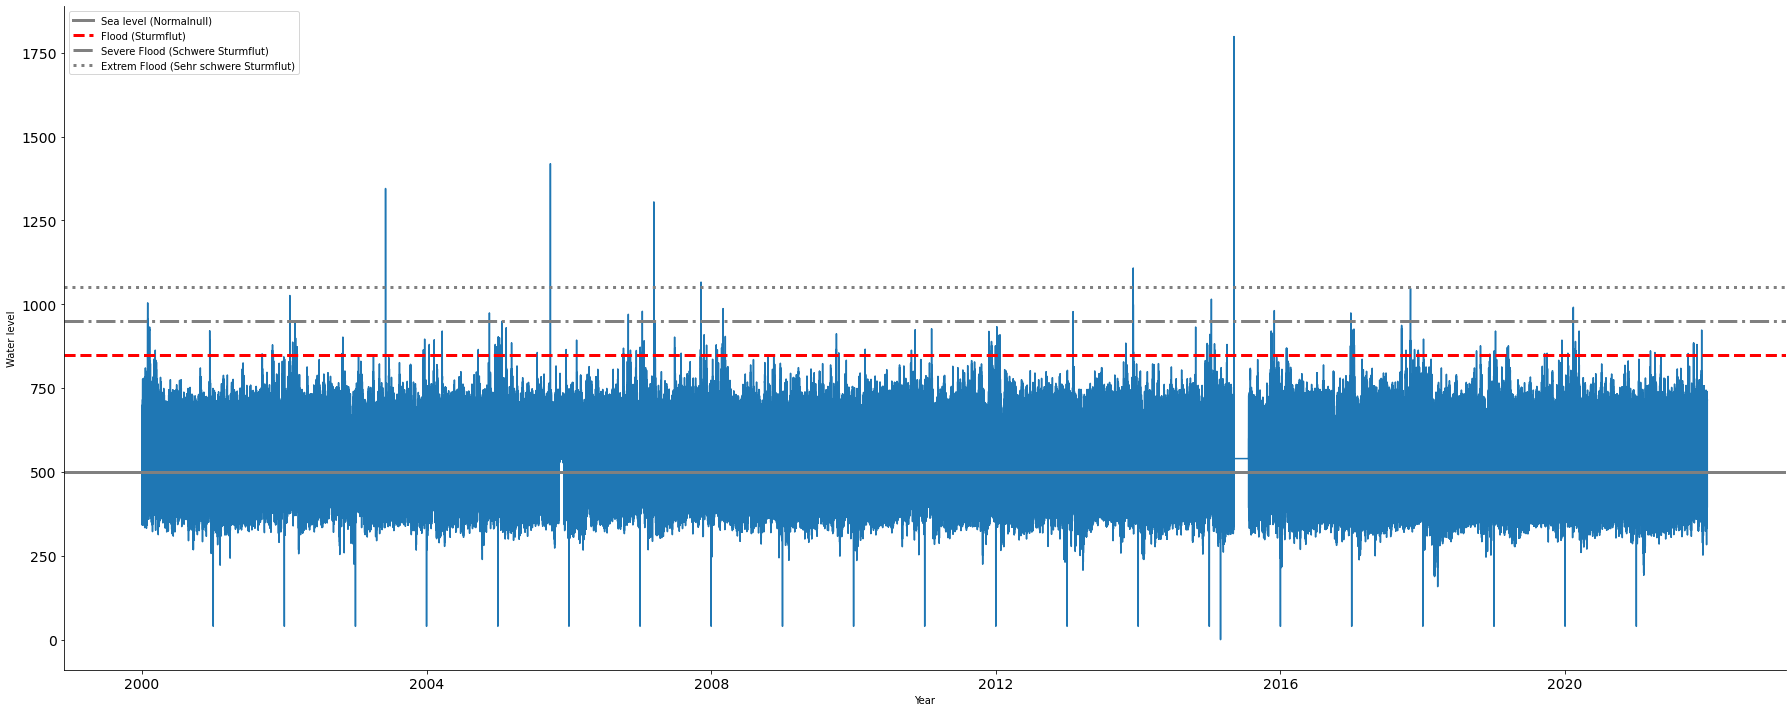

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(stpauli_hourly.index, stpauli_hourly['waterlevel'])


plt.axhline(y=500, color='grey', linestyle='-', label='Sea level (Normalnull)',linewidth=3)
plt.axhline(y=850, color='red', linestyle='--', label='Flood (Sturmflut)',linewidth=3)
plt.axhline(y=950, color='grey', linestyle='-.', label='Severe Flood (Schwere Sturmflut)',linewidth=3)
plt.axhline(y=1050, color='grey', linestyle=':', label='Extrem Flood (Sehr schwere Sturmflut)',linewidth=3)

ax.legend(loc='upper left')
ax.set_xlabel('Year')
ax.set_ylabel('Water level')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tick_params(labelsize=14)

#plt.rcParams["font.family"] = "serif"

# controls default text sizes
'''#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title'''

fig.tight_layout()

In [ ]:
stpauli_hourly.reset_index(inplace=True)
date = stpauli_hourly['date']

## Merging Water (Flood) Data and Weather Data

In [ ]:
full_data_hourly = pd.merge(stpauli_hourly, full_weather, how="inner", left_on='date', right_on='MESS_DATUM')
full_data_hourly.set_index('MESS_DATUM', inplace=True)
timestamp_s = full_data_hourly.index.map(pd.Timestamp.timestamp)
full_data_hourly.reset_index(inplace=True)
full_data_hourly.drop(full_data_hourly.columns[[0,1]], inplace=True, axis=1)
full_data_hourly = full_data_hourly.astype('float32')

# number of seconds and number of days 
day = 24*60*60
year = (365.2425)*day

# add the sine and cosine columns to the dataframe
full_data_hourly['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
full_data_hourly['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
full_data_hourly['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
full_data_hourly['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#full_data_hourly.drop(['Flood'], axis=1, inplace=True)

full_data_hourly.head(-5)

,waterlevel,P_x,R1_x,Wx_x,Wy_x,TT_TU_x,RF_TU_x,R1_y,P_y,Wx_y,...,P,Wx,Wy,R1_y,TT_TU,RF_TU,Day sin,Day cos,Year sin,Year cos
0,478.000000,1009.299988,0.0,-6.128356,-5.142301,-2.0,59.0,0.0,1010.799988,-3.700000,...,1007.599976,-10.927389,-13.022756,0.0,-2.0,60.0,-3.834854e-12,1.000000e+00,0.854080,0.520141
1,429.000000,1008.200012,0.0,-5.668729,-4.756629,-2.5,56.0,0.0,1010.000000,-3.850000,...,1006.599976,-13.788800,-11.570177,0.0,-2.4,59.0,2.588190e-01,9.659258e-01,0.854453,0.519529
2,418.000000,1007.200012,0.0,-5.975147,-5.013743,-3.0,62.0,0.0,1008.900024,-4.949465,...,1005.299988,-14.248426,-11.955850,0.0,-2.5,60.0,5.000000e-01,8.660254e-01,0.854825,0.518916
3,570.000000,1006.099976,0.0,-6.928203,-4.000000,-3.4,65.0,0.0,1007.900024,-5.821938,...,1004.500000,-14.478240,-12.148685,0.0,-2.7,63.0,7.071068e-01,7.071068e-01,0.855197,0.518303
4,662.000000,1005.099976,0.3,-6.894400,-5.785089,-3.4,67.0,0.0,1006.799988,-6.511378,...,1004.000000,-13.558987,-11.377340,0.0,-2.6,65.0,8.660254e-01,5.000000e-01,0.855568,0.517690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128939,39.767399,1001.299988,0.0,-3.723909,-2.150000,3.3,89.0,0.0,1002.500000,-3.897114,...,999.900024,-5.527974,-6.587982,0.0,3.6,84.0,-5.000000e-01,-8.660254e-01,0.003713,0.999993
128940,39.767399,1001.400024,0.0,-4.070319,-2.350000,3.4,87.0,0.0,1002.799988,-3.290896,...,1000.299988,-2.599353,-7.141664,0.0,3.5,88.0,-7.071068e-01,-7.071068e-01,0.004430,0.999990
128941,39.767399,1001.500000,0.0,-3.723909,-2.150000,3.5,85.0,0.0,1002.900024,-3.117692,...,1000.500000,-1.180808,-6.696693,0.0,3.4,89.0,-8.660254e-01,-5.000000e-01,0.005146,0.999987
128942,39.767399,1001.799988,0.0,-3.810512,-2.200000,3.4,85.0,0.0,1002.799988,-3.664801,...,1000.799988,-0.607769,-3.446827,0.0,3.3,88.0,-9.659258e-01,-2.588190e-01,0.005863,0.999983


## Data Preparation

### Train, Validation and Test Data

In [ ]:
num_train_samples = int(0.7 * full_data_hourly.shape[0])
num_val_samples = int(0.2 * full_data_hourly.shape[0])
num_test_samples = full_data_hourly.shape[0] - num_val_samples - num_train_samples

n = full_data_hourly.shape[0]
train_df = full_data_hourly[0:int(n*0.7)]
val_df = full_data_hourly[int(n*0.7):int(n*0.9)]
test_df = full_data_hourly[int(n*0.9):]

mean = train_df.mean()
std = train_df.std()

# Normalize
full_data_hourly_normalized = (full_data_hourly - mean) / std
train_df = (train_df - mean) / std
val_df = (val_df - mean) / std
test_df = (test_df - mean) / std

### Imbalanced Dataset

Flooding events are rather rare and therefore occur a few times a year. In the dataset are many datapoints for which no flood occures compared to a flood ouccuring. The model might therefore not predict floods. To tackle the imbalance we decided to narrow down the dataset to enforce that flood occur more frequenly. 

In [ ]:
imbalance = (full_data_hourly['waterlevel'] >= 850).value_counts()

print("There are ", imbalance[0],'(',np.round(imbalance[0]/(imbalance[1]+imbalance[0]), 4),'%)', " hours when no flood occurs. \n", sep='')
print("There are ", imbalance[1],'(',np.round(imbalance[1]/(imbalance[1]+imbalance[0]), 4),'%)' " hours when a flood occurs. \n", sep='')

There are 128577(0.9971%) hours when no flood occurs. 

There are 372(0.0029%) hours when a flood occurs. 



In [ ]:
stpauli_hourly_flood = full_data_hourly
stpauli_hourly_flood['Flood'] = stpauli_hourly_flood['waterlevel'] >= 850
flood_indeces = stpauli_hourly_flood.index[stpauli_hourly_flood['Flood'] == True].tolist()
stpauli_hourly_flood.drop(stpauli_hourly_flood.columns[24], inplace=True, axis=1)

num_train_samples_flood = int(0.7 * len(flood_indeces))
num_val_samples_flood = int(0.2 * len(flood_indeces))
num_test_samples_flood = len(flood_indeces) - num_val_samples_flood - num_train_samples_flood

stpauli_hourly_flood = full_data_hourly_normalized

In [ ]:
full_data_hourly_normalized

,waterlevel,P_x,R1_x,Wx_x,Wy_x,TT_TU_x,RF_TU_x,R1_y,P_y,Wx_y,...,P,Wx,Wy,R1_y,TT_TU,RF_TU,Day sin,Day cos,Year sin,Year cos
0,-0.723448,-0.516512,-0.184726,-1.623850,-0.925904,-1.604169,-1.277160,-0.188137,-0.406956,-1.103323,...,-0.641441,-1.699722,-1.750420,-0.183043,-1.602324,-1.358201,-0.000675,1.418393,1.180266,0.760339
1,-1.117222,-0.626282,-0.184726,-1.494354,-0.843530,-1.671784,-1.464743,-0.188137,-0.488996,-1.159191,...,-0.738559,-2.195518,-1.528515,-0.183043,-1.656505,-1.422507,0.364885,1.370144,1.180793,0.759472
2,-1.205620,-0.726075,-0.184726,-1.580685,-0.898446,-1.739399,-1.089578,-0.188137,-0.601800,-1.568695,...,-0.864812,-2.275158,-1.587433,-0.183043,-1.670051,-1.358201,0.705533,1.228684,1.181319,0.758605
3,0.015882,-0.835850,-0.184726,-1.849199,-0.681926,-1.793491,-0.901995,-0.188137,-0.704351,-1.893654,...,-0.942505,-2.314977,-1.616892,-0.183043,-1.697141,-1.165281,0.998054,1.003654,1.181844,0.757737
4,0.755212,-0.935643,0.397077,-1.839675,-1.063194,-1.793491,-0.776940,-0.188137,-0.817161,-2.150442,...,-0.991064,-2.155698,-1.499056,-0.183043,-1.683596,-1.036668,1.222513,0.710390,1.182369,0.756869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128944,-4.245171,-1.235022,0.397077,-1.019619,-0.318832,-0.887450,0.286029,-0.188137,-1.196601,-0.950949,...,-1.262994,0.106411,-0.197273,-0.183043,-0.992780,0.570994,-1.364963,0.368876,-0.016656,1.439706
128945,-4.245171,-1.205079,-0.184726,-0.890043,-0.459119,-0.900973,0.348556,-0.188137,-1.165831,-1.079972,...,-1.214435,0.658229,-0.104668,-0.183043,-1.046962,0.570994,-1.223863,0.710390,-0.015643,1.439698
128946,-4.245171,-1.165166,-0.184726,-0.803713,-0.404204,-0.887450,0.348556,-0.188137,-1.135067,-1.082386,...,-1.156166,0.565317,-0.035930,-0.183043,-1.006325,0.635300,-0.999403,1.003654,-0.014630,1.439689
128947,-4.245171,-1.125246,-0.184726,-0.567313,-0.432964,-0.928019,0.598666,-0.188137,-1.104303,-1.020213,...,-1.127032,0.904072,0.239019,-0.183043,-0.965689,0.635300,-0.706883,1.228684,-0.013616,1.439680


In [ ]:
def narrowed_data(inbalanced_df, total_window_length, event_indeces):

    narrowed_data = list()

    for event in event_indeces:
        for i in range(total_window_length):
            narrowed_data.append(inbalanced_df[event-total_window_length+i:event+i])
    
    return np.asarray(narrowed_data)

In [ ]:
total_length = 60

narrowed_data_flood = narrowed_data(full_data_hourly_normalized, total_length, flood_indeces)

noflood_indeces = full_data_hourly_normalized.sample(n=len(flood_indeces)).index

narrowed_data_noflood = narrowed_data(full_data_hourly_normalized, total_length, noflood_indeces)

balanced_data = np.concatenate((narrowed_data_flood,narrowed_data_noflood))

In [ ]:
train_balanced_data = balanced_data[:num_train_samples_flood*total_length]
val_balanced_data   = balanced_data[num_train_samples_flood*total_length:(num_train_samples_flood+num_val_samples_flood)*total_length]
test_balanced_data  = balanced_data[(num_train_samples_flood+num_val_samples_flood)*total_length:]

In [ ]:
future_length = 12
split_point = total_length - future_length

train_input = train_balanced_data[:,:split_point,:]
train_label = train_balanced_data[:,split_point:,0]

train_input = train_input.astype('float32')
train_label = train_label.astype('float32')

val_input = val_balanced_data[:,:split_point,:]
val_label = val_balanced_data[:,split_point:,0]

val_input = val_input.astype('float32')
val_label = val_label.astype('float32')

test_input = test_balanced_data[:,:split_point,:]
test_label = test_balanced_data[:,split_point:,0]

test_input = test_input.astype('float32')
test_label = test_label.astype('float32')

In [ ]:
balanced_train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
balanced_val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
balanced_test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))

balanced_test_input, balanced_test_label = test_input, test_label

def preprocess(dataset):

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(20)

    return dataset

balanced_train_dataset = preprocess(balanced_train_dataset)
balanced_test_dataset  = preprocess(balanced_test_dataset)
balanced_val_dataset   = preprocess(balanced_val_dataset)

### Creating Tensorflow Datasets

In [ ]:
# Source: Approach 4 from this blog post https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/

def timeseries_dataset_multistep_combined(dataset, target_slice, input_sequence_length, output_sequence_length, sampling_rate=1, batch_size=32, shuffle=False, start_index=0, end_index=None):
    if end_index == None:
        end_index = len(dataset) -1

    time_series_dataset = tf.keras.utils.timeseries_dataset_from_array(
        dataset,
        targets = None,
        sampling_rate = sampling_rate,
        sequence_length = input_sequence_length + output_sequence_length,
        shuffle = shuffle,
        batch_size = batch_size,
        start_index = start_index,
        end_index = end_index)
    
    def split_feature_label(x):
        return x[:, :input_sequence_length, :], x[:, input_sequence_length:, target_slice]

    time_series_dataset = time_series_dataset.map(split_feature_label)
     
    return time_series_dataset
 

In [ ]:
sampling_rate = 1
sequence_length = 48
output_sequence_length = 12
delay = sampling_rate * (sequence_length + output_sequence_length - 1)
batch_size = 120

train_dataset = timeseries_dataset_multistep_combined(
    full_data_hourly_normalized.to_numpy(),
    target_slice = slice(0,1,None),
    sampling_rate = sampling_rate,
    input_sequence_length=sequence_length,
    output_sequence_length = output_sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset = timeseries_dataset_multistep_combined(
    full_data_hourly_normalized.to_numpy(),
    target_slice = slice(0,1,None),
    sampling_rate = sampling_rate,
    input_sequence_length=sequence_length,
    output_sequence_length = output_sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_multistep_combined(
    full_data_hourly_normalized.to_numpy(),
    target_slice = slice(0,1,None),
    sampling_rate = sampling_rate,
    input_sequence_length=sequence_length,
    output_sequence_length = output_sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

In [ ]:
sampling_rate = 1
sequence_length_feedback = 48
output_sequence_length_feedback = 12
delay = sampling_rate * (sequence_length_feedback + output_sequence_length_feedback - 1)
batch_size = 120

train_dataset_feedback = timeseries_dataset_multistep_combined(
    full_data_hourly_normalized.to_numpy(),
    target_slice = slice(0,24,None),
    sampling_rate = sampling_rate,
    input_sequence_length=sequence_length_feedback,
    output_sequence_length = output_sequence_length_feedback,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset_feedback = timeseries_dataset_multistep_combined(
    full_data_hourly_normalized.to_numpy(),
    target_slice = slice(0,24,None),
    sampling_rate = sampling_rate,
    input_sequence_length=sequence_length_feedback,
    output_sequence_length = output_sequence_length_feedback,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

test_dataset_feedback = timeseries_dataset_multistep_combined(
    full_data_hourly_normalized.to_numpy(),
    target_slice = slice(0,24,None),
    sampling_rate = sampling_rate,
    input_sequence_length=sequence_length_feedback,
    output_sequence_length = output_sequence_length_feedback,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

In [ ]:
for i,j in train_dataset.take(1):
    print(i.shape, j.shape)
    #print(j, j)

(120, 48, 24) (120, 12, 1)


# Tensorflow Models

### Custom Loss Function
The Mean Squared Error (MSE) loss function can be low for the imbalanded dataset even if the model underestimates the water level when a flood occurs, as the flood is not as likely. For unseen datapoints the model might therefore be unable to predicting a flooding event. Besides narrowing down the dataset, the model prediction might also improve if we increase the loss if the model fails to predict the high water level of a flood. 

In [ ]:
def custom_mse_loss(y_actual,y_pred):
    mse = tf.reduce_mean(kb.square(y_actual-y_pred))
    flood = tf.constant([2.26])
    actual_flood = tf.math.greater_equal(y_actual, flood)
    predicted_flood = tf.math.greater_equal(y_pred, flood)
    right_predictions = tf.cast(tf.math.logical_and(actual_flood, tf.math.logical_not(predicted_flood)),tf.float32)
    added_error = tf.reduce_sum(tf.math.multiply(right_predictions,20))
    mse = tf.add(mse, added_error)
    return mse

## Simple LSTM Model

In [ ]:
# Get input, target dims
for batch in train_dataset.take(1):
    inputs, targets = batch

# Two Layer LSTM
inputs = keras.Input(shape=(inputs.shape[1],inputs.shape[2]))
x = layers.LSTM(32, return_sequences=True, name='norm1')(inputs)
#x = layers.Dropout(0.3, name='norm2')(x)
x = layers.LSTM(12, name='norm3')(x)
#x = layers.Dropout(0.3, name='norm4')(x)
outputs = layers.Dense(output_sequence_length, name='norm5')(x)

# One Layer LSTM
inputs_one = keras.Input(shape=(inputs.shape[1],inputs.shape[2]))
x_one = layers.LSTM(32)(inputs_one)
outputs_one = layers.Dense(output_sequence_length)(x_one)

### MSE Loss Function

#### One Layer LSTM

In [ ]:
model_one_mse = keras.Model(inputs_one, outputs_one)

callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_mse_one.keras',
                                     save_best_only=True)
]

model_one_mse.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_one_mse = model_one_mse.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
752/752 [==============================] - 26s 23ms/step - loss: 0.2660 - mae: 0.3296 - root_mean_squared_error: 0.5158 - val_loss: 0.1305 - val_mae: 0.2141 - val_root_mean_squared_error: 0.3612
Epoch 2/20
752/752 [==============================] - 13s 17ms/step - loss: 0.0964 - mae: 0.1819 - root_mean_squared_error: 0.3105 - val_loss: 0.1071 - val_mae: 0.1925 - val_root_mean_squared_error: 0.3273
Epoch 3/20
752/752 [==============================] - 13s 17ms/step - loss: 0.0837 - mae: 0.1685 - root_mean_squared_error: 0.2894 - val_loss: 0.0987 - val_mae: 0.1857 - val_root_mean_squared_error: 0.3142
Epoch 4/20
752/752 [==============================] - 13s 17ms/step - loss: 0.0781 - mae: 0.1615 - root_mean_squared_error: 0.2794 - val_loss: 0.0936 - val_mae: 0.1782 - val_root_mean_squared_error: 0.3059
Epoch 5/20
752/752 [==============================] - 12s 16ms/step - loss: 0.0749 - mae: 0.1571 - root_mean_squared_error: 0.2737 - val_loss: 0.0906 - val_mae: 0.1709 - val_ro

#### Two Layer LSTM (Basic LSTM)

In [ ]:
model_mse = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_mse.keras',
                                     save_best_only=True)
]

model_mse.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_mse = model_mse.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
752/752 [==============================] - 17s 19ms/step - loss: 0.2942 - mae: 0.3532 - root_mean_squared_error: 0.5424 - val_loss: 0.1338 - val_mae: 0.2222 - val_root_mean_squared_error: 0.3658
Epoch 2/20
752/752 [==============================] - 14s 18ms/step - loss: 0.0997 - mae: 0.1892 - root_mean_squared_error: 0.3158 - val_loss: 0.1140 - val_mae: 0.2022 - val_root_mean_squared_error: 0.3376
Epoch 3/20
752/752 [==============================] - 15s 19ms/step - loss: 0.0870 - mae: 0.1743 - root_mean_squared_error: 0.2950 - val_loss: 0.1073 - val_mae: 0.1971 - val_root_mean_squared_error: 0.3276
Epoch 4/20
752/752 [==============================] - 14s 18ms/step - loss: 0.0806 - mae: 0.1659 - root_mean_squared_error: 0.2838 - val_loss: 0.1005 - val_mae: 0.1869 - val_root_mean_squared_error: 0.3169
Epoch 5/20
752/752 [==============================] - 14s 18ms/step - loss: 0.0763 - mae: 0.1603 - root_mean_squared_error: 0.2763 - val_loss: 0.0952 - val_mae: 0.1796 - val_ro

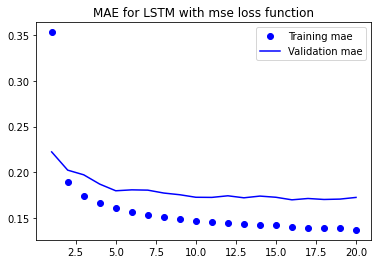

In [ ]:
loss_mse = history_mse.history['mae']
val_loss_mse = history_mse.history['val_mae']
epochs = range(1, len(loss_mse)+1)
plt.figure()
plt.plot(epochs, loss_mse, 'bo', label='Training mae')
plt.plot(epochs, val_loss_mse, 'b', label='Validation mae')
plt.title('MAE for LSTM with mse loss function')
plt.legend()
plt.show()

### Custom Loss Function

#### One Layer LSTM

In [ ]:
model_one_custom = keras.Model(inputs_one, outputs_one)

callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_custom_one.keras',
                                     save_best_only=True)
]

model_one_custom.compile(optimizer='adam', loss=custom_mse_loss, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_one_custom = model_one_custom.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
752/752 [==============================] - 35s 43ms/step - loss: 78.3914 - mae: 0.3376 - root_mean_squared_error: 0.5254 - val_loss: 71.6920 - val_mae: 0.2172 - val_root_mean_squared_error: 0.3654
Epoch 2/20
752/752 [==============================] - 32s 43ms/step - loss: 62.8363 - mae: 0.1862 - root_mean_squared_error: 0.3149 - val_loss: 67.2148 - val_mae: 0.1961 - val_root_mean_squared_error: 0.3321
Epoch 3/20
752/752 [==============================] - 32s 43ms/step - loss: 55.0526 - mae: 0.1685 - root_mean_squared_error: 0.2906 - val_loss: 63.1541 - val_mae: 0.1809 - val_root_mean_squared_error: 0.3152
Epoch 4/20
752/752 [==============================] - 35s 46ms/step - loss: 50.6250 - mae: 0.1603 - root_mean_squared_error: 0.2792 - val_loss: 61.3468 - val_mae: 0.1776 - val_root_mean_squared_error: 0.3089
Epoch 5/20
752/752 [==============================] - 34s 45ms/step - loss: 47.8059 - mae: 0.1555 - root_mean_squared_error: 0.2732 - val_loss: 60.5353 - val_mae: 0.173

#### Two Layer LSTM (Basic LSTM)

In [ ]:
model_custom_loss = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm.keras',
                                     save_best_only=True)
]

model_custom_loss.compile(optimizer='adam', loss=custom_mse_loss, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_custom = model_custom_loss.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
752/752 [==============================] - 16s 18ms/step - loss: 37.8264 - mae: 0.1366 - root_mean_squared_error: 0.2314 - val_loss: 50.8578 - val_mae: 0.1716 - val_root_mean_squared_error: 0.3035
Epoch 2/20
752/752 [==============================] - 13s 17ms/step - loss: 36.6272 - mae: 0.1345 - root_mean_squared_error: 0.2273 - val_loss: 53.2582 - val_mae: 0.1682 - val_root_mean_squared_error: 0.3011
Epoch 3/20
752/752 [==============================] - 13s 17ms/step - loss: 37.0879 - mae: 0.1355 - root_mean_squared_error: 0.2286 - val_loss: 48.3533 - val_mae: 0.1719 - val_root_mean_squared_error: 0.3010
Epoch 4/20
752/752 [==============================] - 13s 17ms/step - loss: 35.9435 - mae: 0.1343 - root_mean_squared_error: 0.2279 - val_loss: 50.6462 - val_mae: 0.1701 - val_root_mean_squared_error: 0.3007
Epoch 5/20
752/752 [==============================] - 17s 23ms/step - loss: 34.7551 - mae: 0.1322 - root_mean_squared_error: 0.2228 - val_loss: 52.6984 - val_mae: 0.169

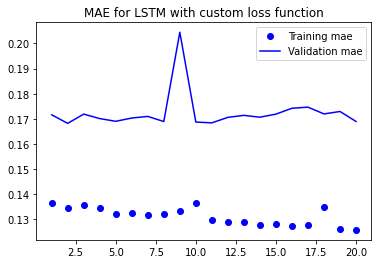

In [ ]:
loss_custom = history_custom.history['mae']
val_loss_custom = history_custom.history['val_mae']
epochs = range(1, len(loss_custom)+1)
plt.figure()
plt.plot(epochs, loss_custom, 'bo', label='Training mae')
plt.plot(epochs, val_loss_custom, 'b', label='Validation mae')
plt.title('MAE for LSTM with custom loss function')
plt.legend()
plt.show()

### Visualization

In [ ]:
# Code for plotting from https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output/notebook

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    history = history * std[0] + mean[0]
    true_future = true_future * std[0] + mean[0]
    prediction = prediction * std[0] + mean[0]
    STEP = 1
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history),'go', label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.axhline(850, color='y', label='Sturmflut')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
# Code for plotting from https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output/notebook

def multi_step_plot_compare(history, true_future, prediction_1, prediction_2, label1, label2):
    history = history * std[0] + mean[0]
    true_future = true_future * std[0] + mean[0]
    prediction_1 = prediction_1 * std[0] + mean[0]
    prediction_2 = prediction_2 * std[0] + mean[0]
    STEP = 1
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y')
    
    plt.plot(num_in, np.array(history),'go', label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'g^',
           label='True Future')
    if prediction_1.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction_1), 'rx',
                 label=label1)
    if prediction_2.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction_2), 'bx',
                 label=label2)
    plt.axhline(850, color='y', label='Sturmflut')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
stpauli_lstm_custom = keras.models.load_model('st_pauli_lstm.keras', compile=False)
stpauli_lstm_mse = keras.models.load_model('st_pauli_lstm_mse.keras')
stpauli_lstm_one_custom = keras.models.load_model('st_pauli_lstm_custom_one.keras', compile=False)
stpauli_lstm_one_mse = keras.models.load_model('st_pauli_lstm_mse_one.keras')

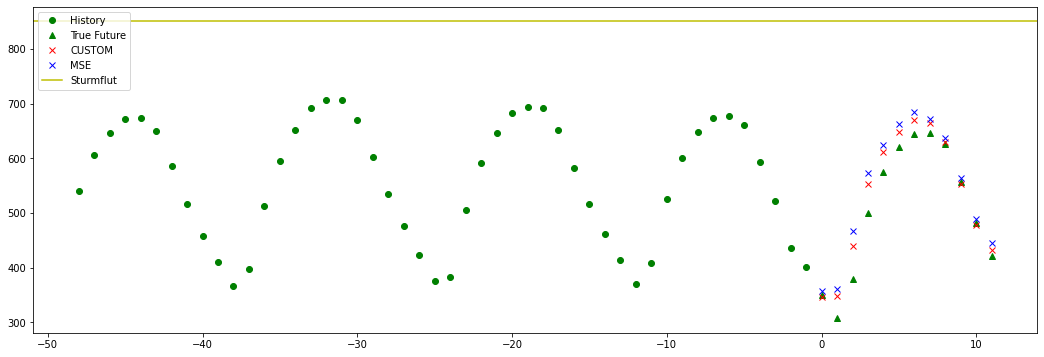

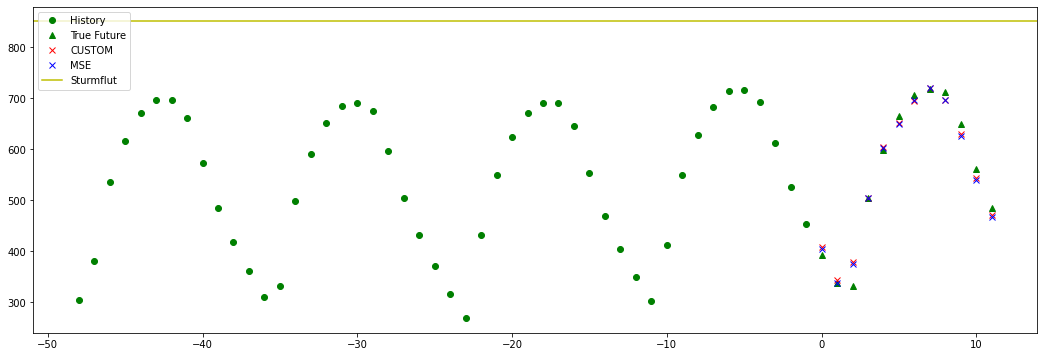

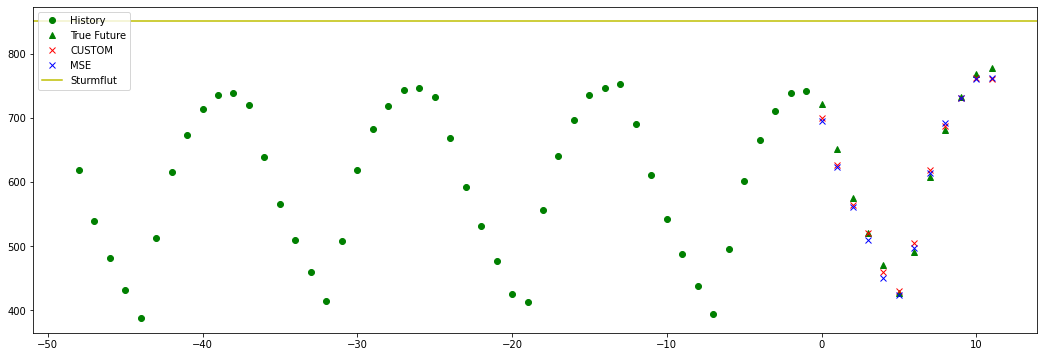

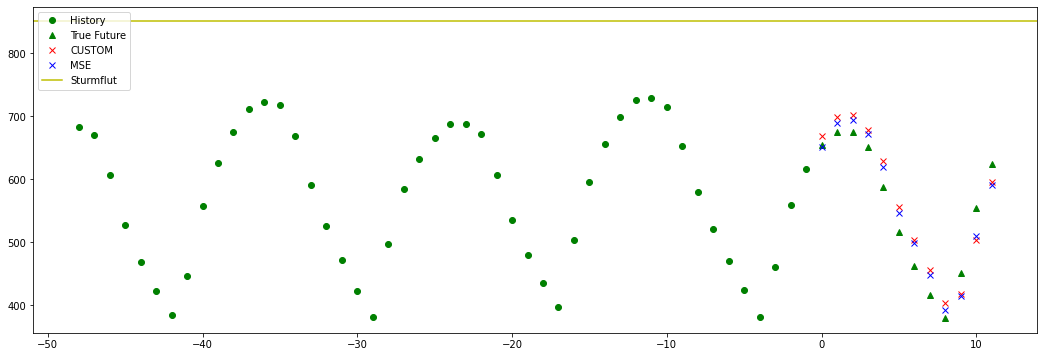

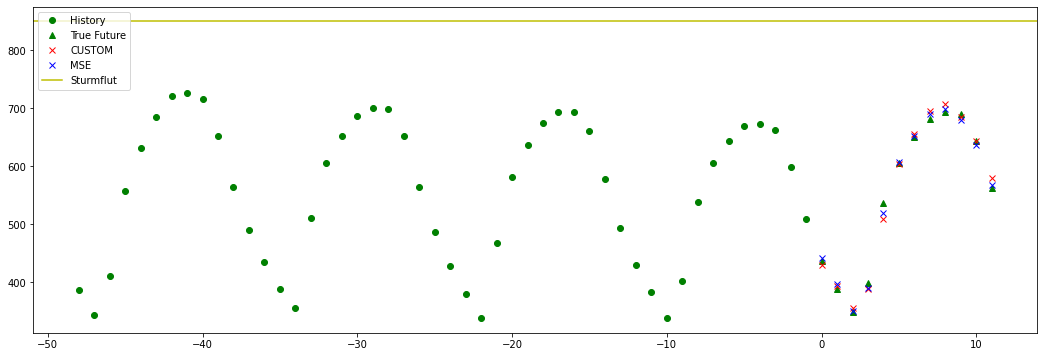

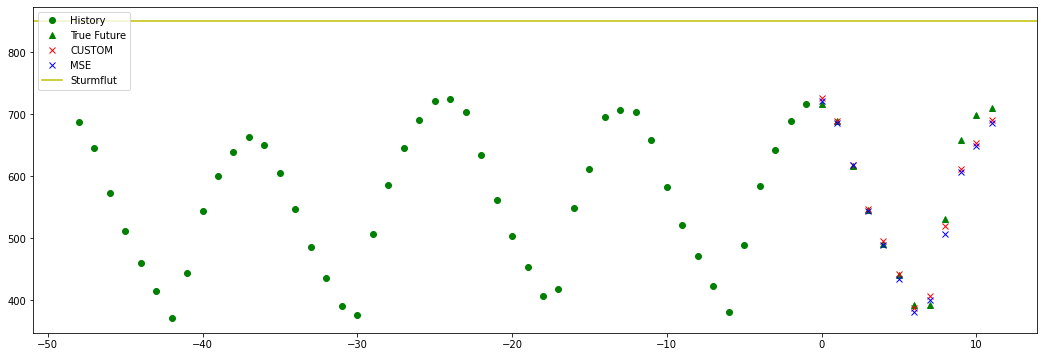

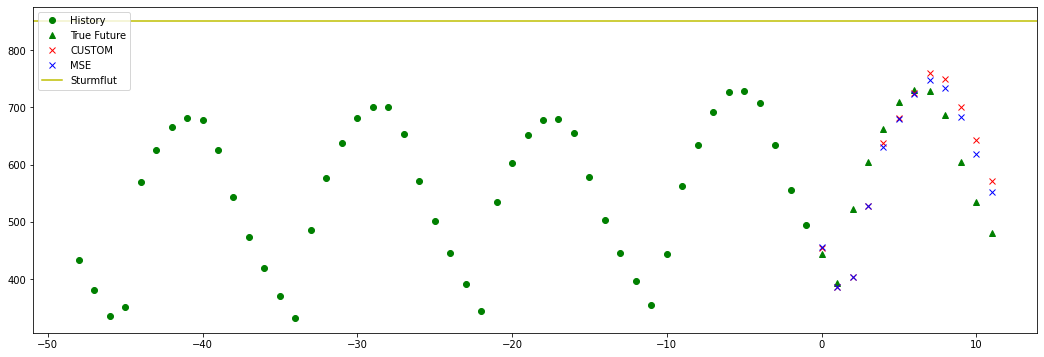

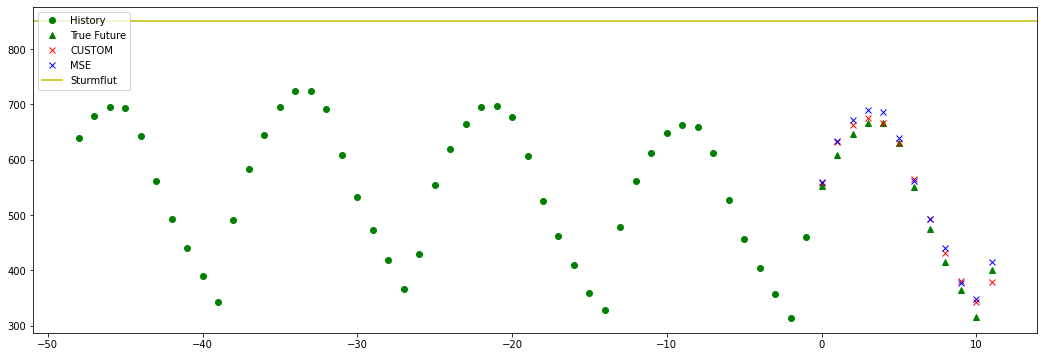

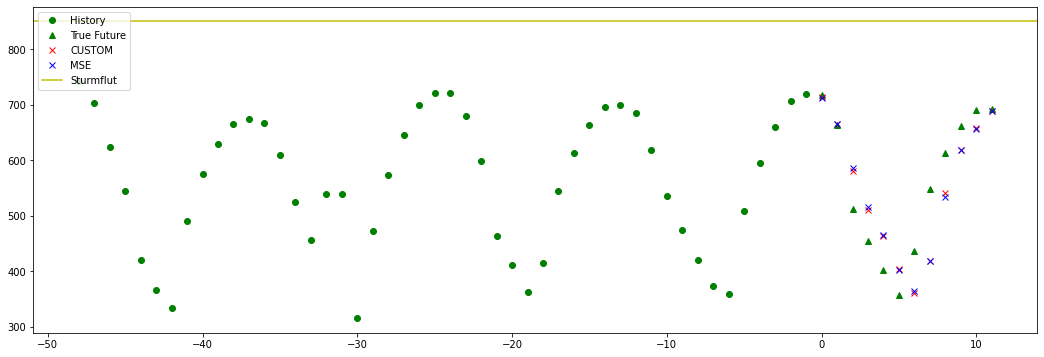

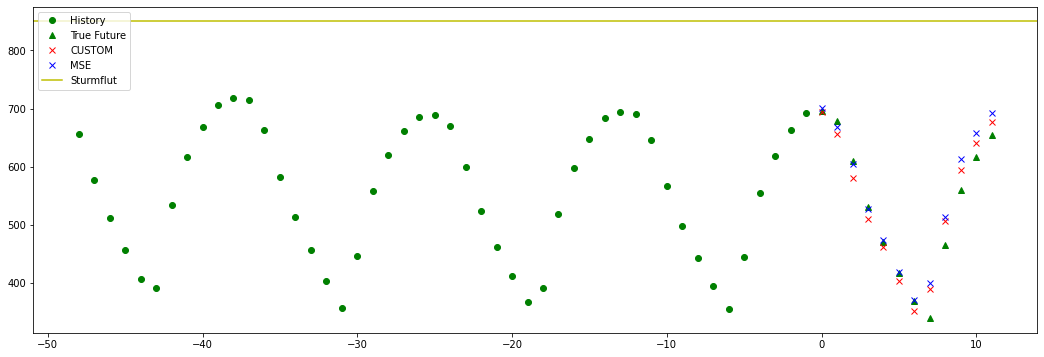

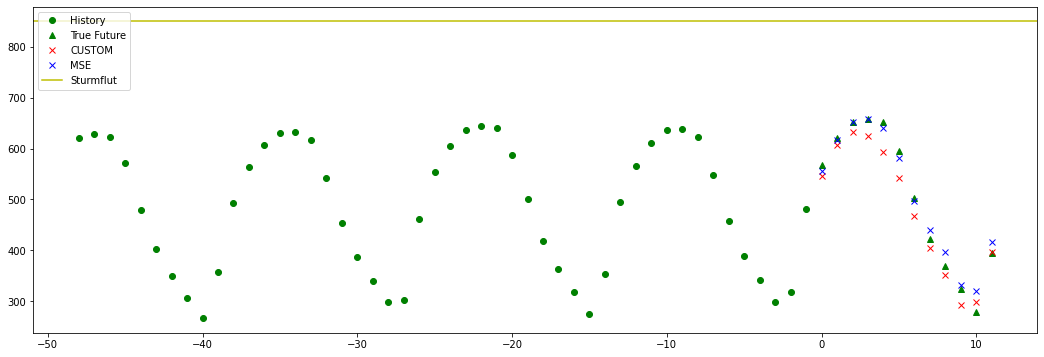

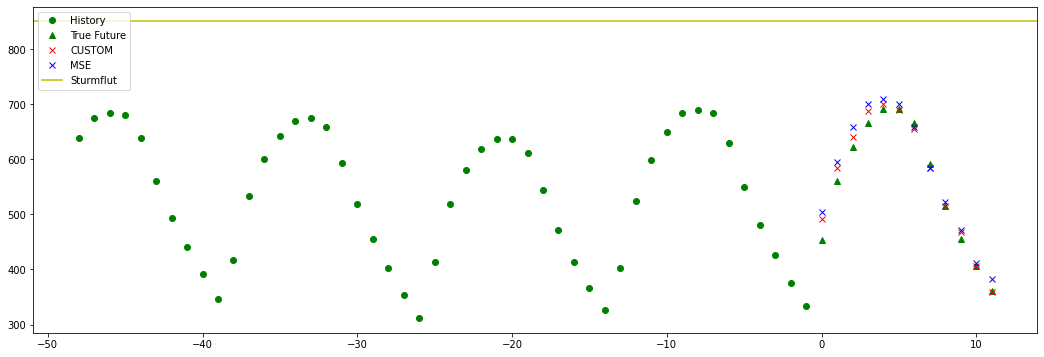

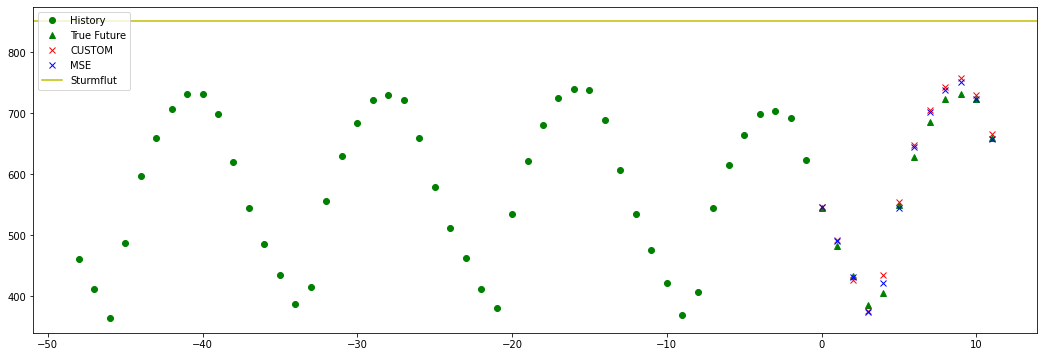

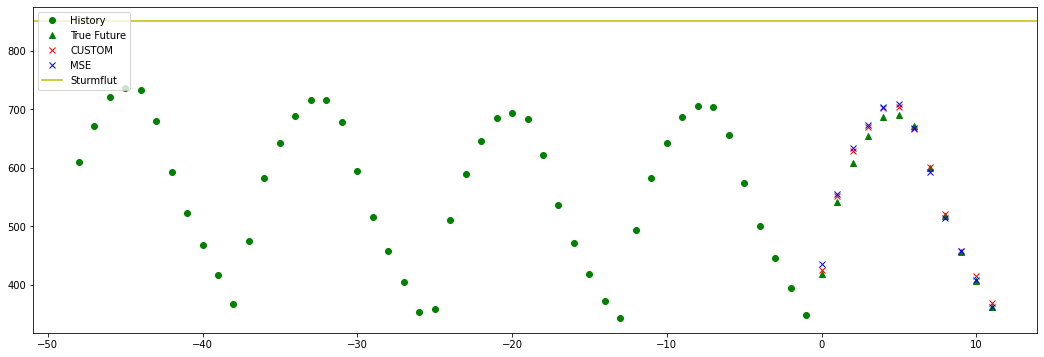

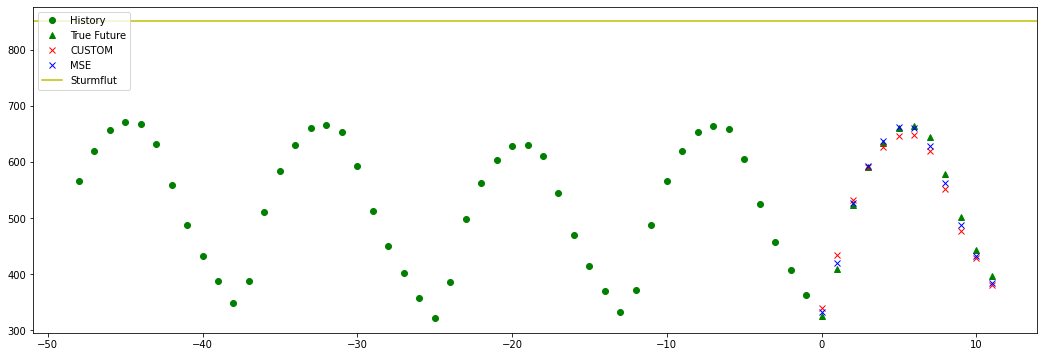

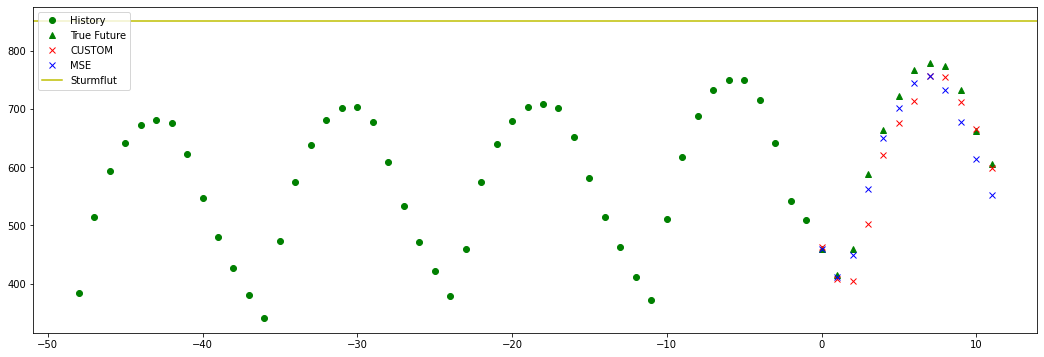

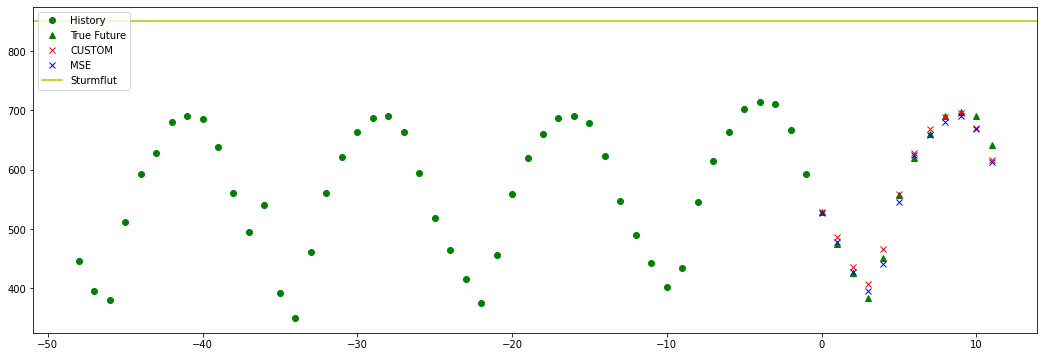

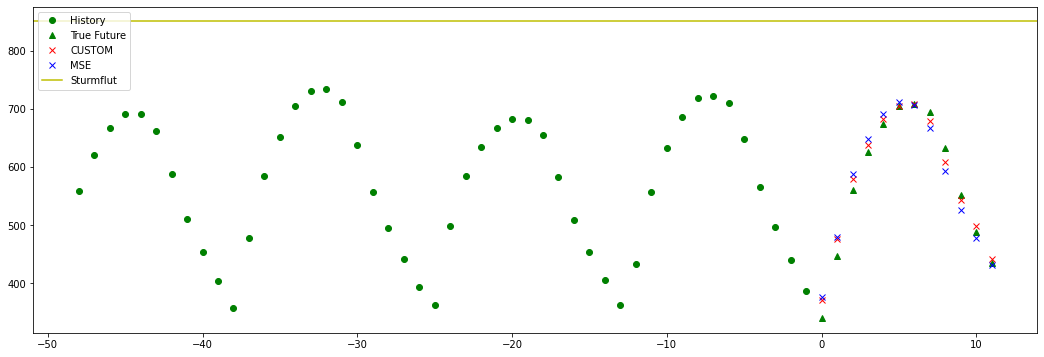

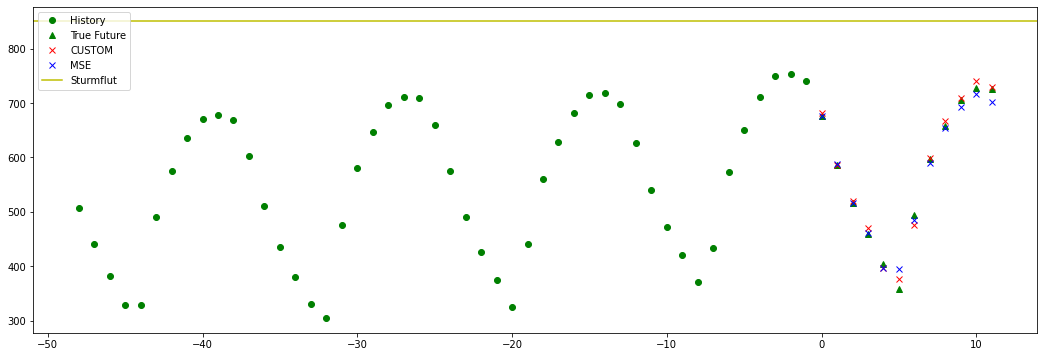

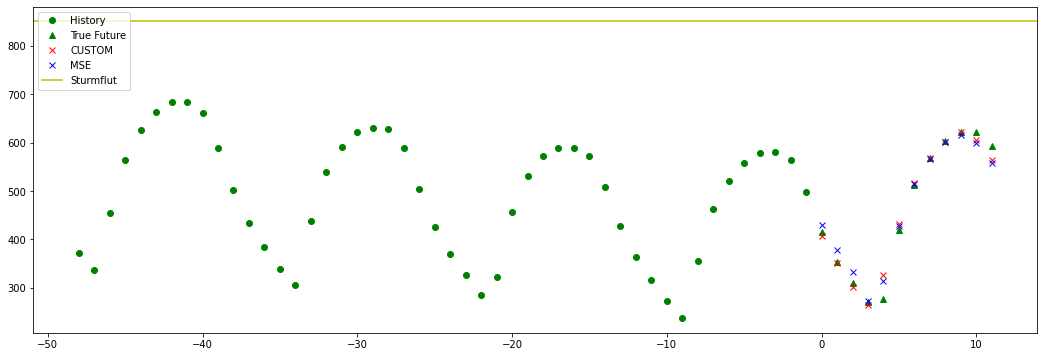

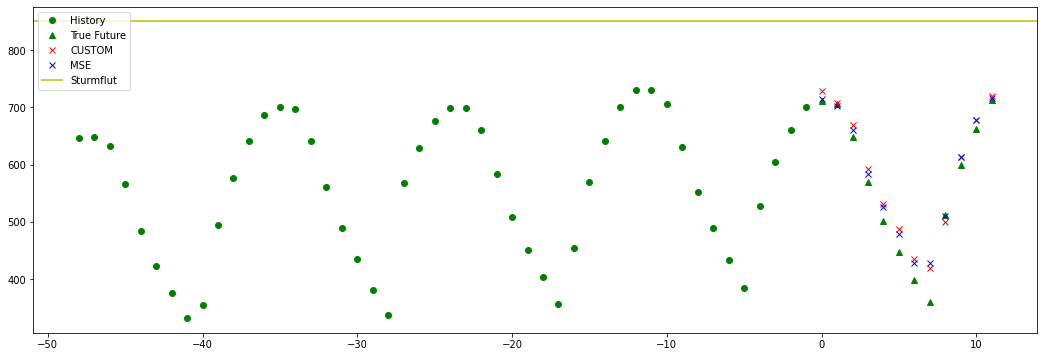

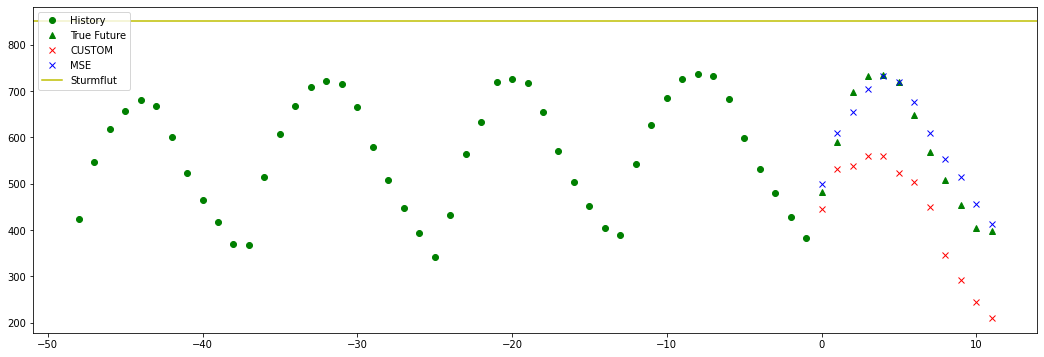

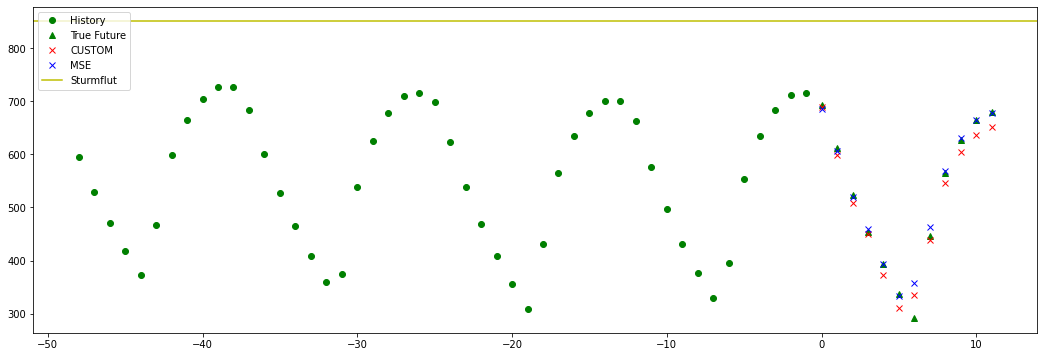

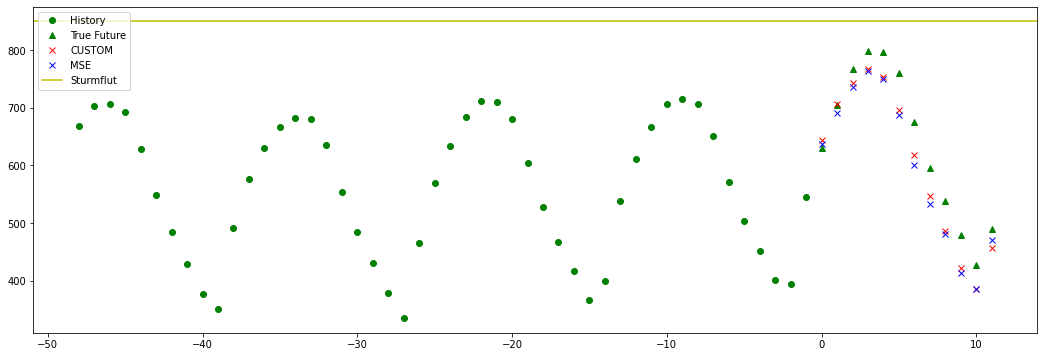

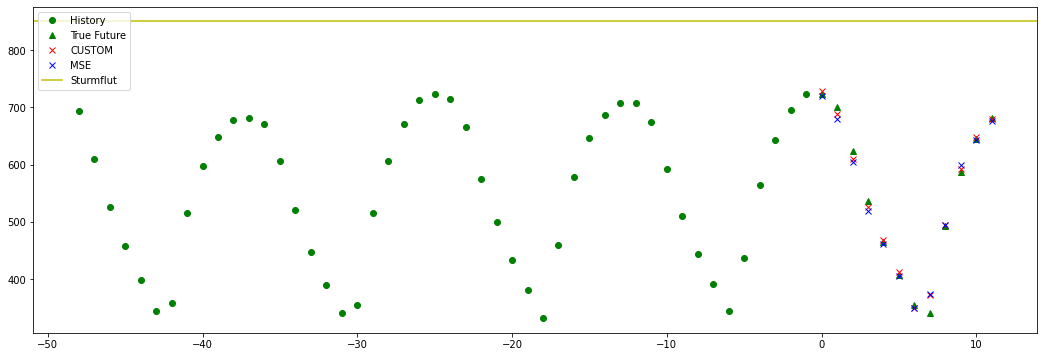

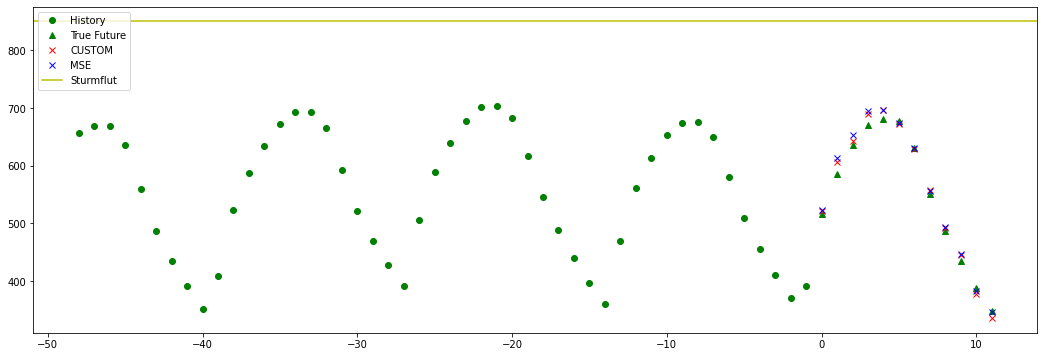

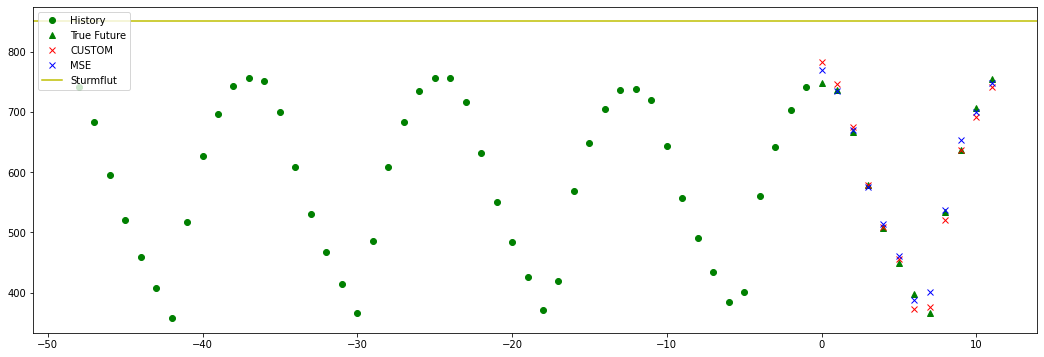

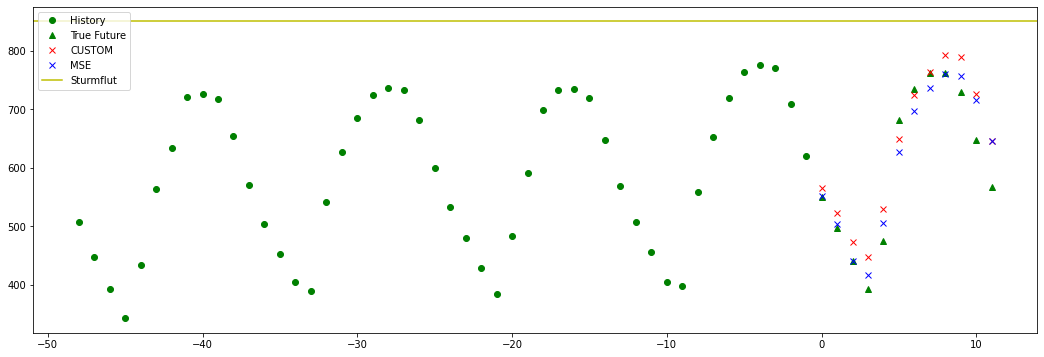

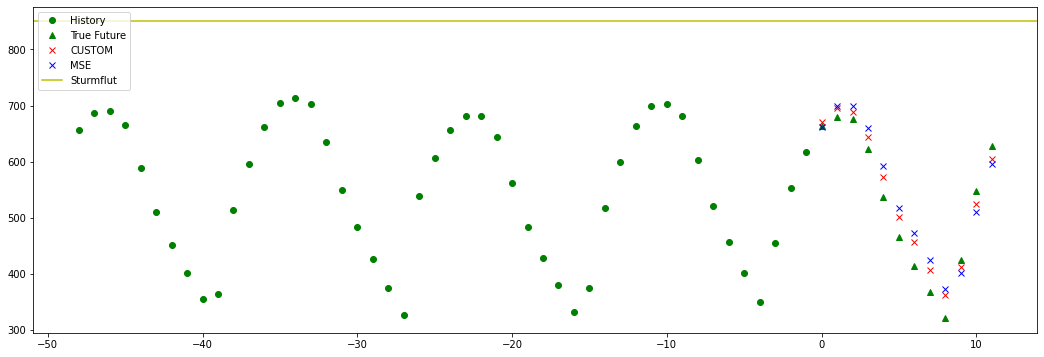

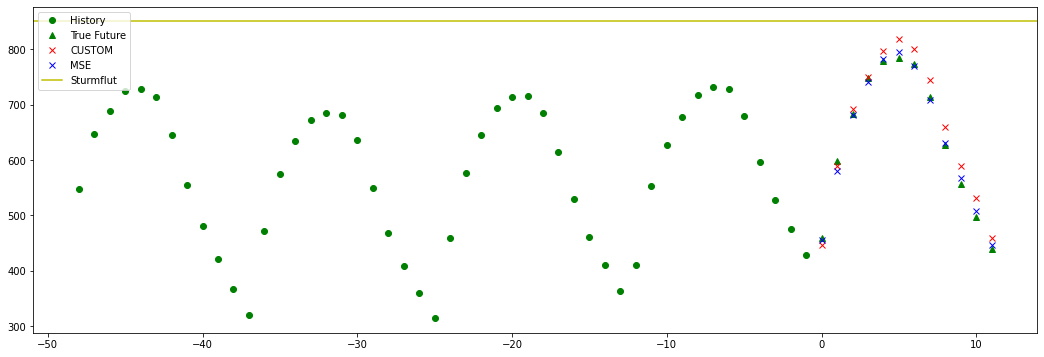

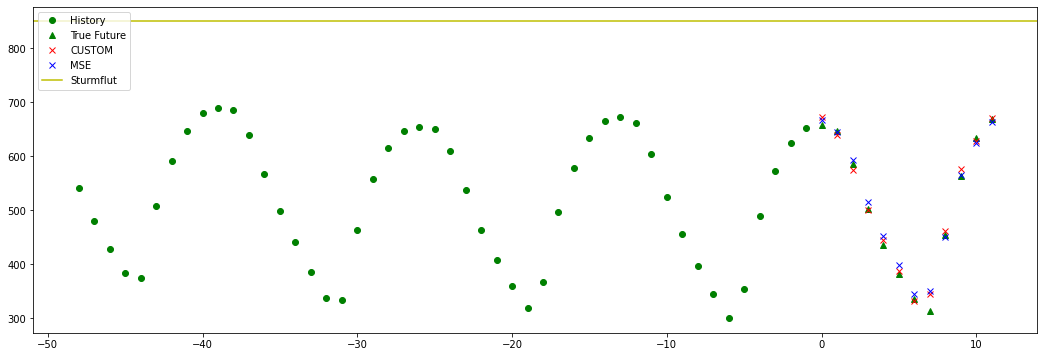

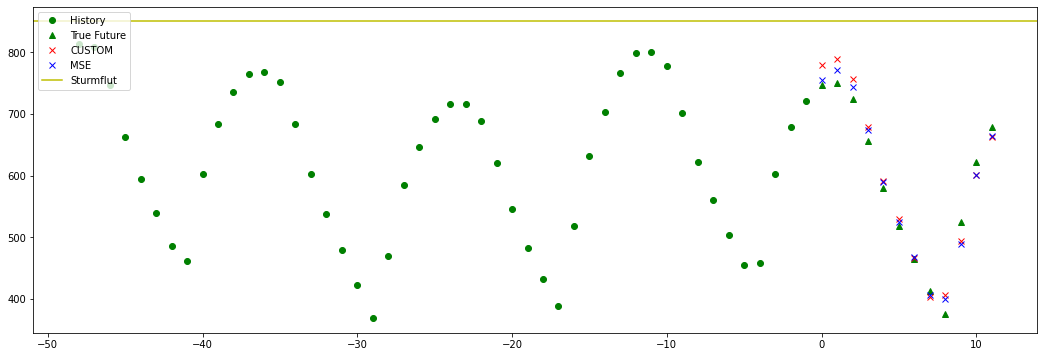

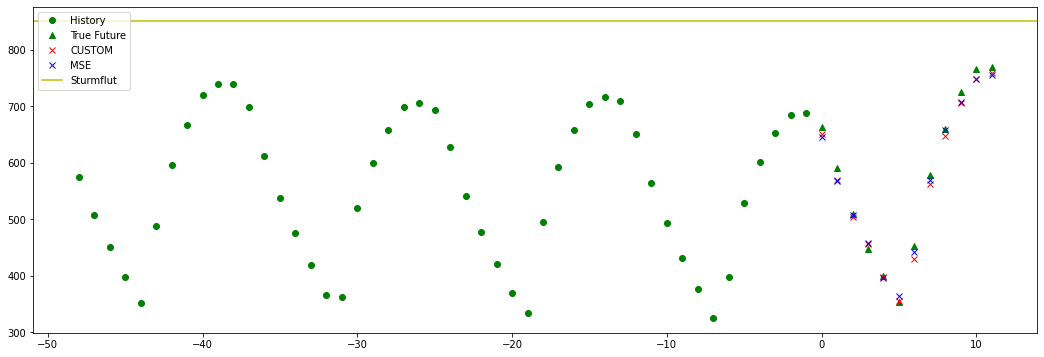

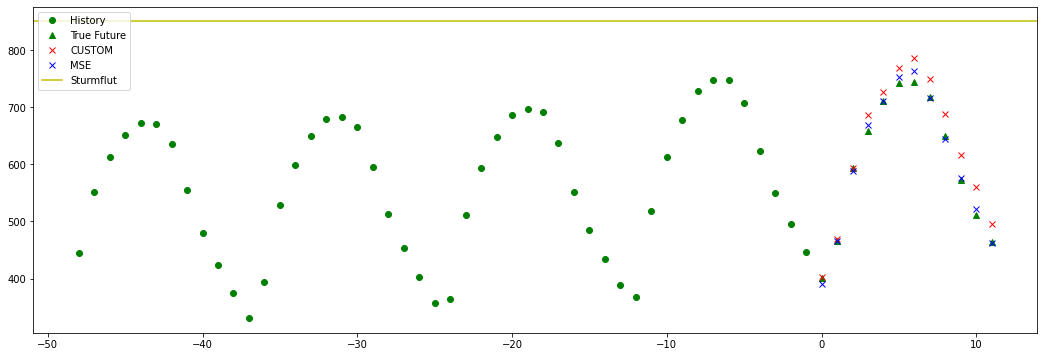

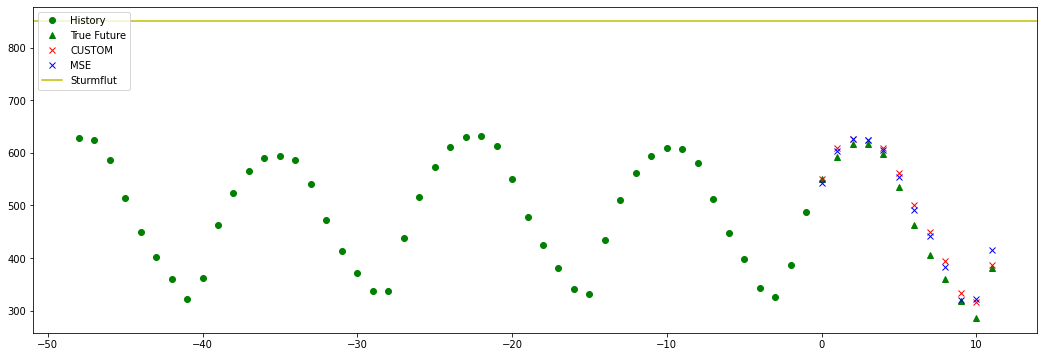

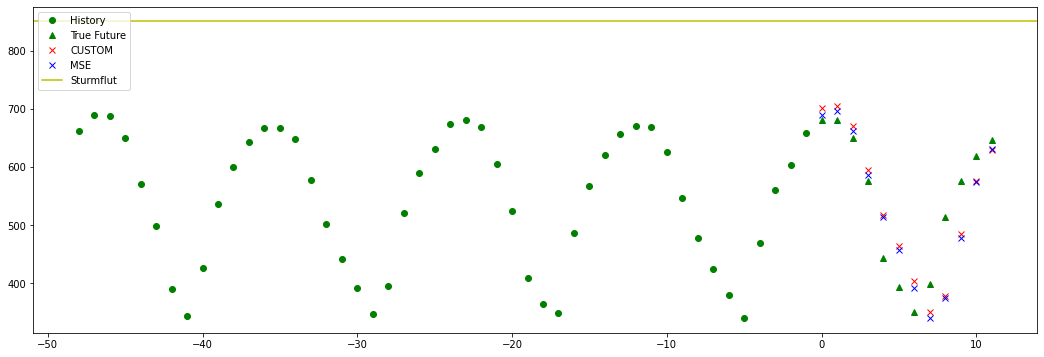

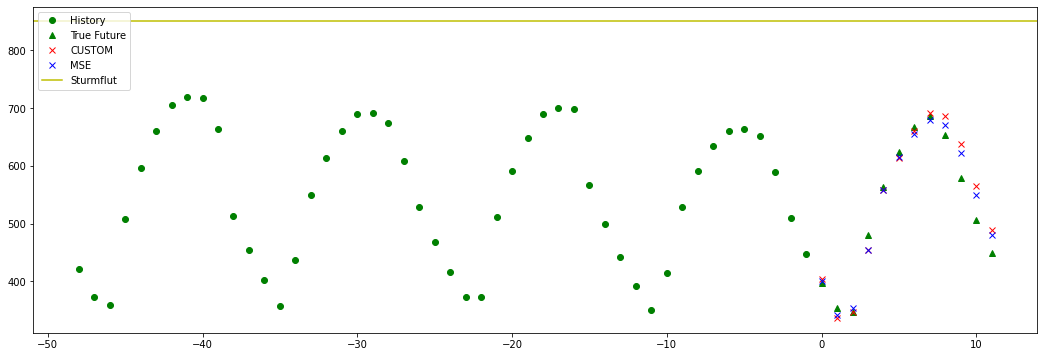

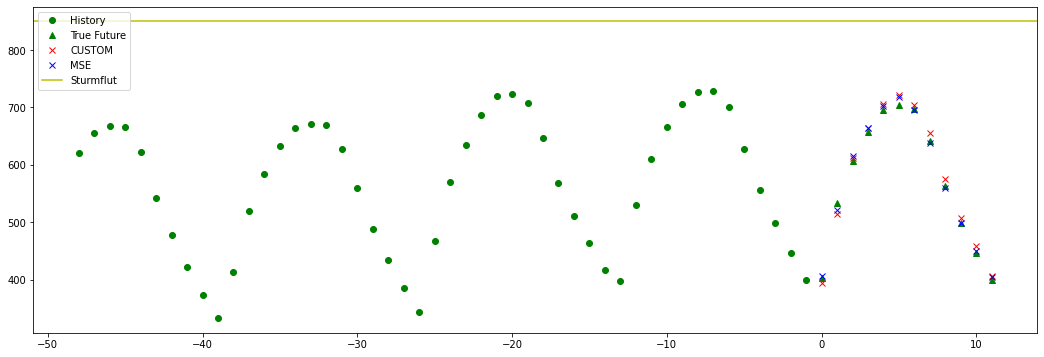

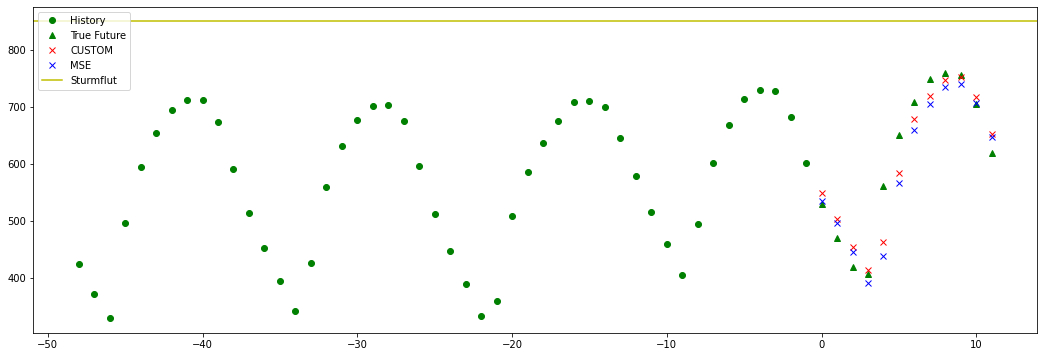

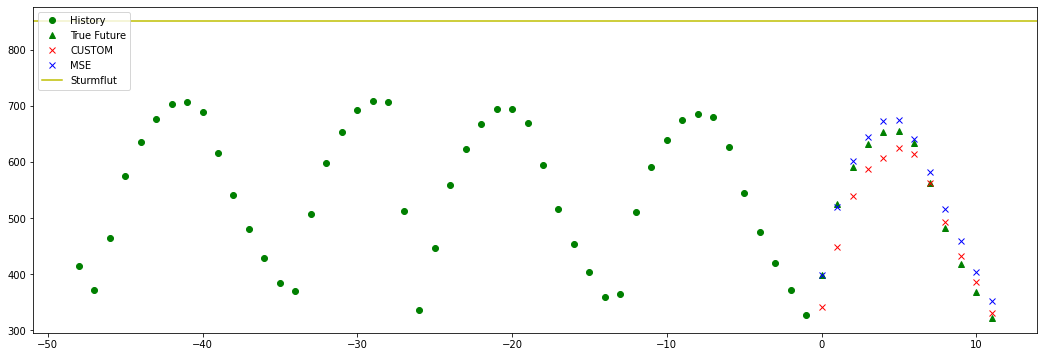

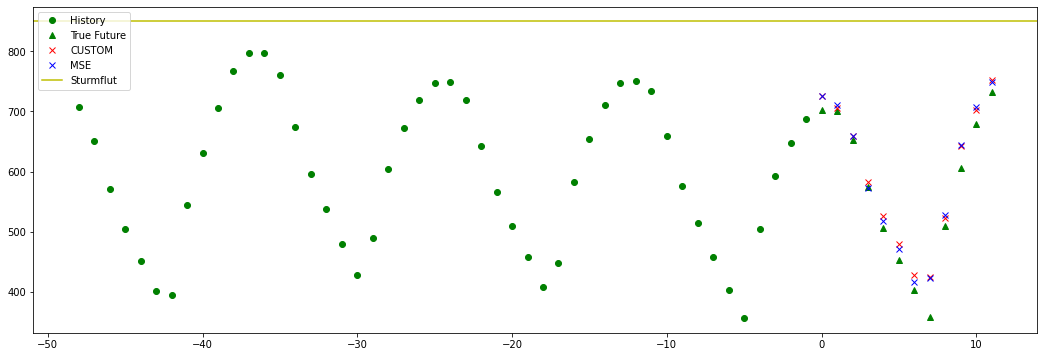

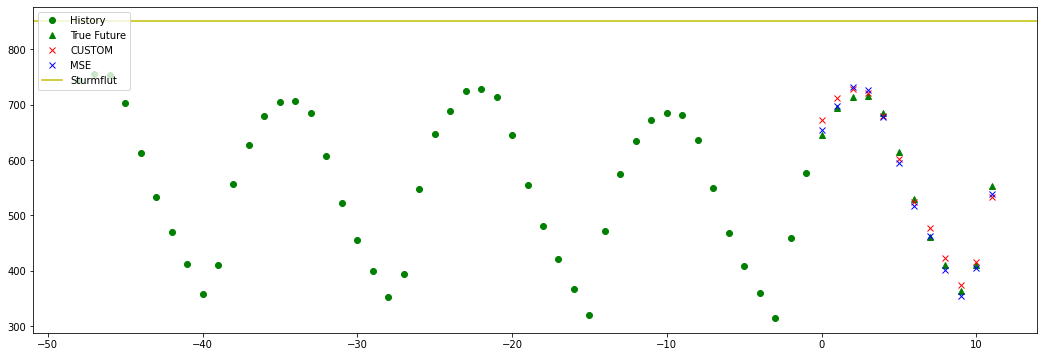

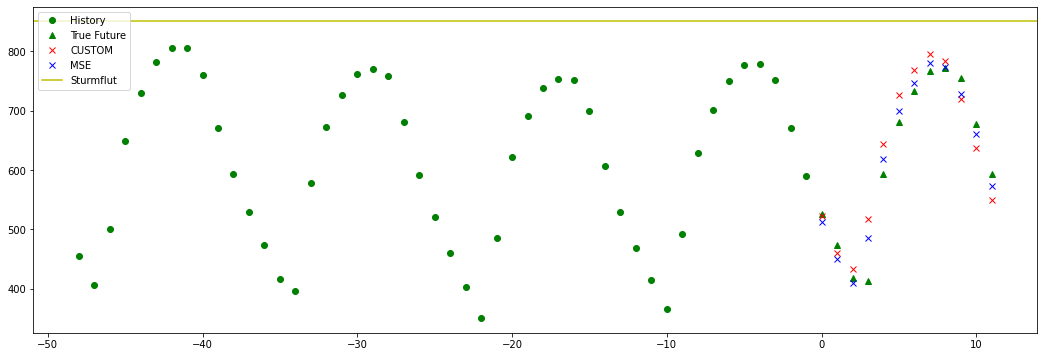

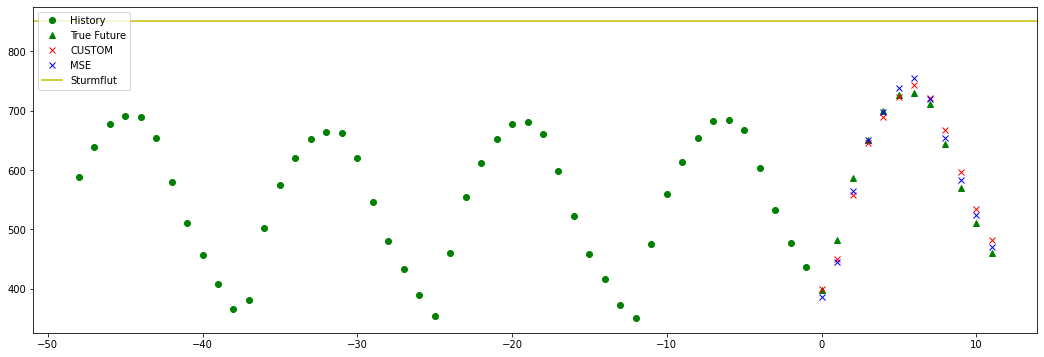

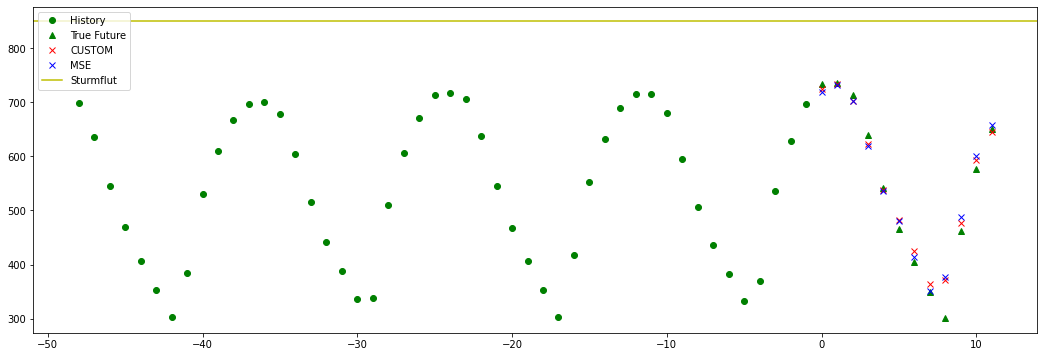

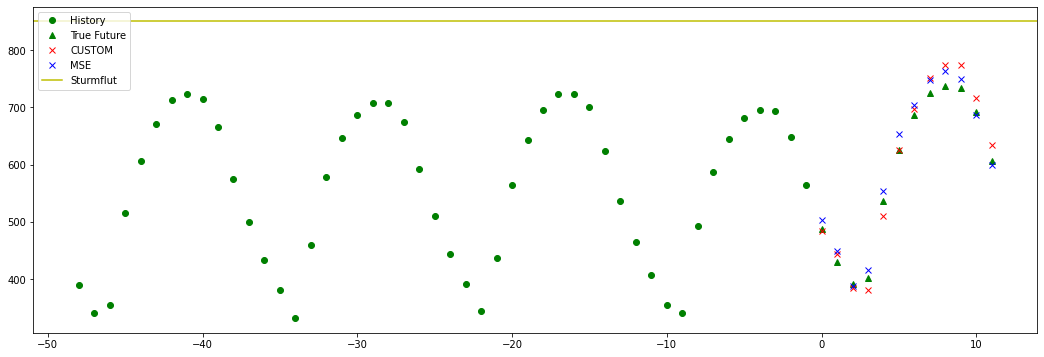

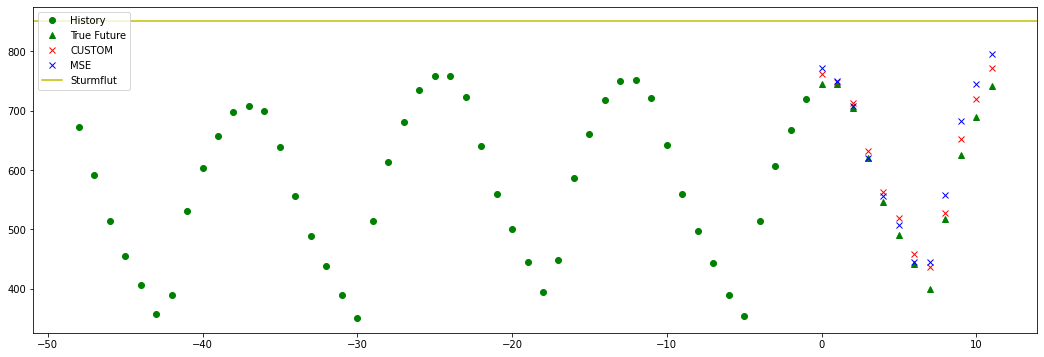

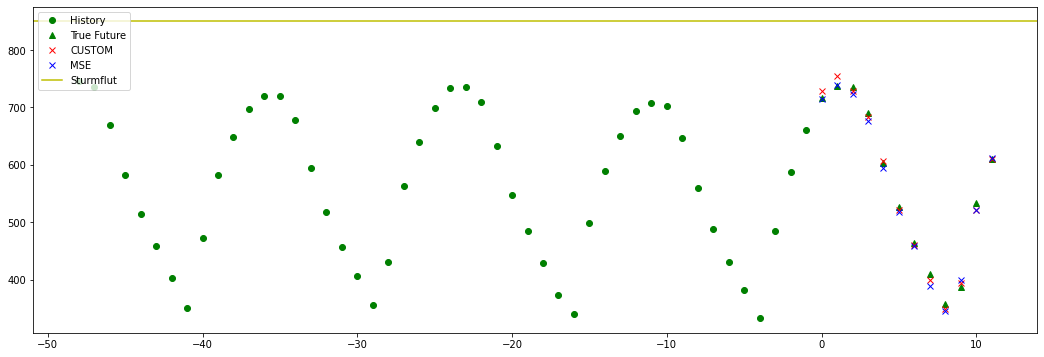

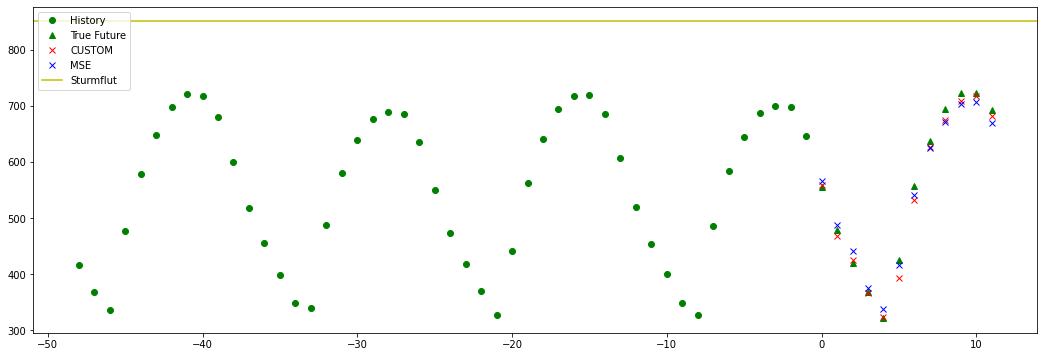

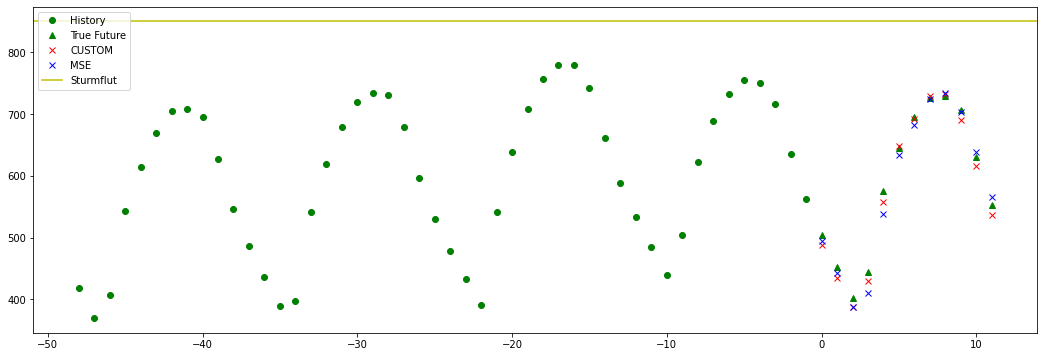

In [ ]:
for x, y in val_dataset.take(50):
    multi_step_plot_compare(x[0,:,0], y[0], stpauli_lstm_custom.predict(x)[0], stpauli_lstm_mse.predict(x)[0], label1='CUSTOM', label2='MSE')

## Feedback LSTM Model

[Source](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model)

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units_1, units_2, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units_1 = units_1
        self.units_2 = units_2
        self.lstm_cell_1 = tf.keras.layers.LSTMCell(units_1)
        self.lstm_cell_2 = tf.keras.layers.LSTMCell(units_2)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn_1 = tf.keras.layers.RNN(self.lstm_cell_1, return_state=True,return_sequences=True)
        self.lstm_rnn_2 = tf.keras.layers.RNN(self.lstm_cell_2, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state_1 = self.lstm_rnn_1(inputs)
        x, *state_2 = self.lstm_rnn_2(x)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state_1, state_2

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state_1, state_2 = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
          # Use the last prediction as input.
          x = prediction
          # Execute one lstm step.
          x_1, state_1 = self.lstm_cell_1(x, states=state_1,
                                    training=training)
          x_1, state_2 = self.lstm_cell_2(x_1, states=state_2,
                                    training=training)
          
          # Convert the lstm output to a prediction.
          prediction = self.dense(x_1)
          # Add the prediction to the output.
          predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

### MSE Loss Function

In [ ]:
feedback_model_mse = FeedBack(units_1=32, units_2=12, out_steps=output_sequence_length, num_features=24)
callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_autoreg_mse',
                                     save_best_only=True, save_format='tf')
]

feedback_model_mse.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_ar = feedback_model_mse.fit(train_dataset_feedback,
                    epochs=20,
                    validation_data=val_dataset_feedback,
                    callbacks=callbacks)

model_ar_mse = keras.models.load_model('st_pauli_lstm_autoreg_mse', compile=False)

Epoch 1/20
752/752 [==============================] - 152s 196ms/step - loss: 0.4964 - mae: 0.4479 - root_mean_squared_error: 0.7046 - val_loss: 0.4057 - val_mae: 0.3709 - val_root_mean_squared_error: 0.6370
Epoch 2/20
752/752 [==============================] - 145s 193ms/step - loss: 0.3535 - mae: 0.3363 - root_mean_squared_error: 0.5946 - val_loss: 0.3814 - val_mae: 0.3438 - val_root_mean_squared_error: 0.6176
Epoch 3/20
752/752 [==============================] - 148s 196ms/step - loss: 0.3354 - mae: 0.3163 - root_mean_squared_error: 0.5792 - val_loss: 0.3716 - val_mae: 0.3306 - val_root_mean_squared_error: 0.6096
Epoch 4/20
752/752 [==============================] - 145s 193ms/step - loss: 0.3266 - mae: 0.3058 - root_mean_squared_error: 0.5715 - val_loss: 0.3626 - val_mae: 0.3210 - val_root_mean_squared_error: 0.6022
Epoch 5/20
752/752 [==============================] - 143s 191ms/step - loss: 0.3214 - mae: 0.3000 - root_mean_squared_error: 0.5669 - val_loss: 0.3611 - val_mae: 0.318

### Custom Loss Function

In [ ]:
def custom_mse_loss_feedback(y_actual,y_pred):
    mse = tf.reduce_mean(kb.square(y_actual-y_pred))
    flood = tf.constant([2.26])
    y_actual_sliced = tf.squeeze(tf.slice(y_actual, [0, 0, 0], [0, 12, 1]))
    y_pred_sliced = tf.squeeze(tf.slice(y_pred, [0, 0, 0], [0, 12, 1]))
    actual_flood = tf.math.greater_equal(y_actual_sliced, flood)
    predicted_flood = tf.math.greater_equal(y_pred_sliced, flood)
    right_predictions = tf.cast(tf.math.logical_and(actual_flood, tf.math.logical_not(predicted_flood)),tf.float32)
    added_error = tf.reduce_sum(tf.math.multiply(right_predictions,20))
    mse = tf.add(mse, added_error)
    return mse

In [ ]:
train_dataset_feedback

<MapDataset element_spec=(TensorSpec(shape=(None, None, 24), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 24), dtype=tf.float64, name=None))>

In [ ]:
feedback_model_custom = FeedBack(units_1=32, units_2=12, out_steps=output_sequence_length, num_features=24)
callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_autoreg_custom',
                                     save_best_only=True, save_format='tf')
]

feedback_model_custom.compile(optimizer='adam', loss=custom_mse_loss_feedback, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_ar_custom = feedback_model_custom.fit(train_dataset_feedback,
                    epochs=20,
                    validation_data=val_dataset_feedback,
                    callbacks=callbacks)

model_ar_custom = keras.models.load_model('st_pauli_lstm_autoreg_custom', compile=False)

Epoch 1/20
752/752 [==============================] - 146s 187ms/step - loss: 0.4977 - mae: 0.4510 - root_mean_squared_error: 0.7055 - val_loss: 0.4074 - val_mae: 0.3728 - val_root_mean_squared_error: 0.6383
Epoch 2/20
752/752 [==============================] - 140s 186ms/step - loss: 0.3574 - mae: 0.3409 - root_mean_squared_error: 0.5978 - val_loss: 0.3828 - val_mae: 0.3467 - val_root_mean_squared_error: 0.6187
Epoch 3/20
752/752 [==============================] - 139s 185ms/step - loss: 0.3386 - mae: 0.3205 - root_mean_squared_error: 0.5819 - val_loss: 0.3698 - val_mae: 0.3322 - val_root_mean_squared_error: 0.6081
Epoch 4/20
752/752 [==============================] - 138s 184ms/step - loss: 0.3284 - mae: 0.3086 - root_mean_squared_error: 0.5730 - val_loss: 0.3641 - val_mae: 0.3227 - val_root_mean_squared_error: 0.6034
Epoch 5/20
752/752 [==============================] - 139s 184ms/step - loss: 0.3214 - mae: 0.3014 - root_mean_squared_error: 0.5669 - val_loss: 0.3591 - val_mae: 0.319

### Visualization

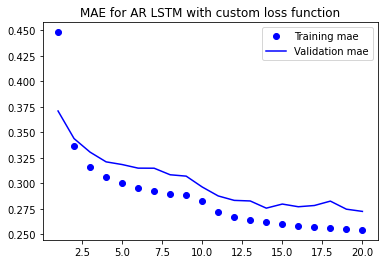

In [ ]:
loss_custom = history_ar.history['mae']
val_loss_custom = history_ar.history['val_mae']
epochs = range(1, len(loss_custom)+1)
plt.figure()
plt.plot(epochs, loss_custom, 'bo', label='Training mae')
plt.plot(epochs, val_loss_custom, 'b', label='Validation mae')
plt.title('MAE for AR LSTM with custom loss function')
plt.legend()
plt.show()

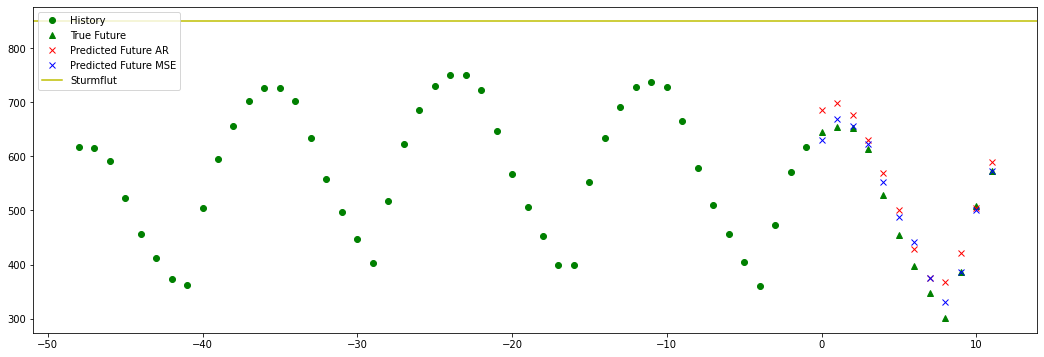

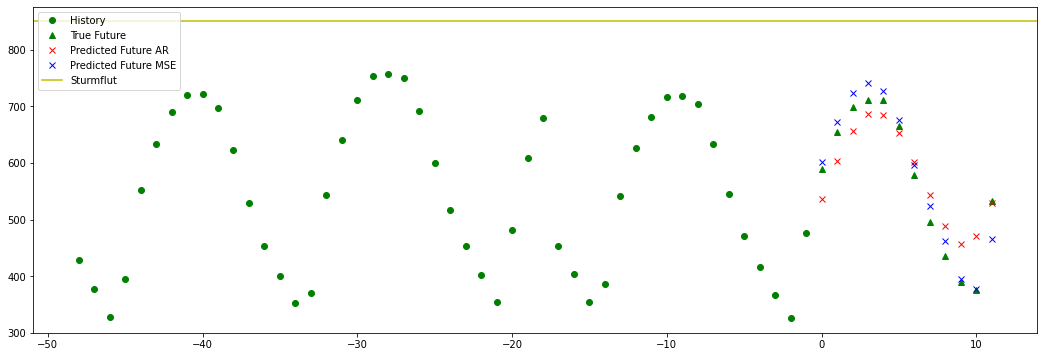

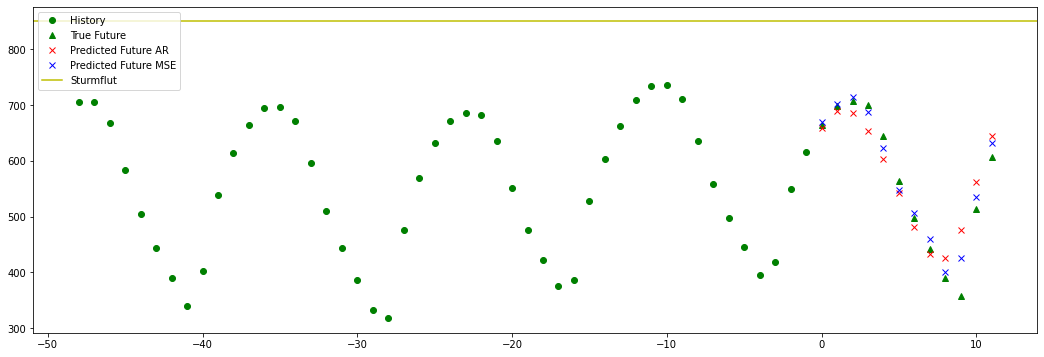

In [ ]:
for x, y in test_dataset.take(3):
    multi_step_plot_compare(x[0,:,0], y[0],
                            model_ar_custom.predict(x)[0,:,0],
                            stpauli_lstm_mse.predict(x)[0],
                            label1='Predicted Future AR',
                            label2='Predicted Future MSE')

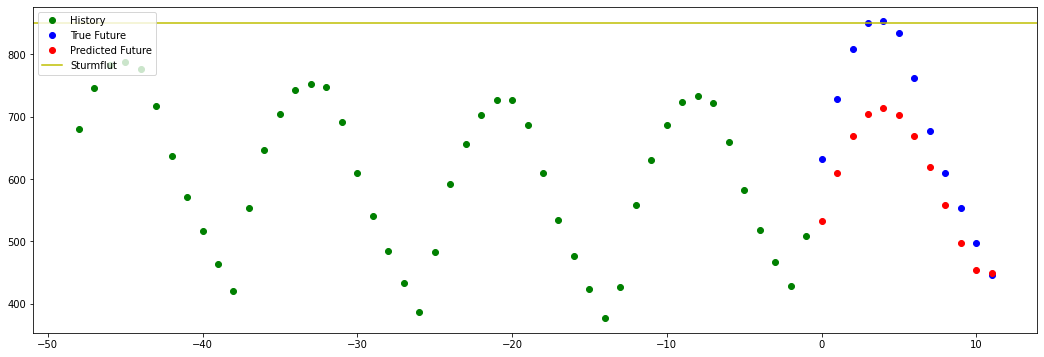

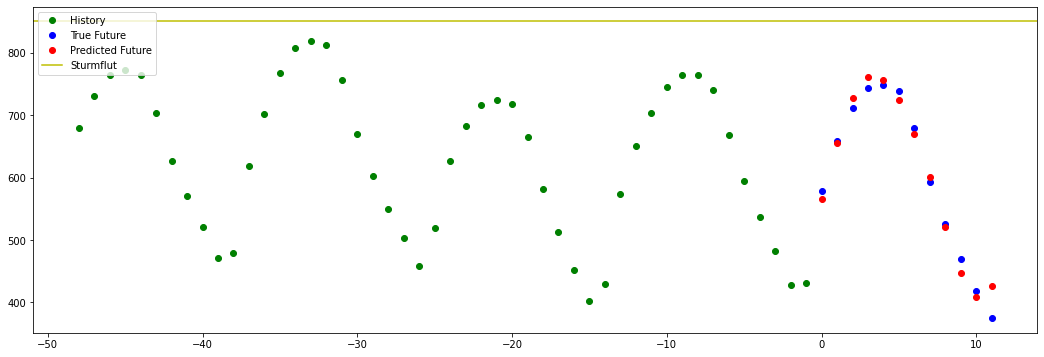

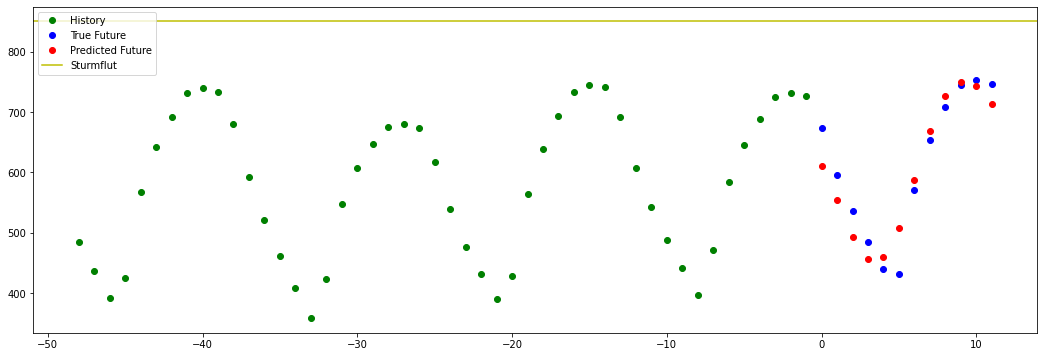

In [ ]:
for x, y in test_dataset.take(3):
    multi_step_plot(x[0,:,0], y[0], model_ar_mse.predict(x)[0,:,0])

## LSTM using the more balanced Dataset (NOT included in the paper)

### MSE Loss Function

#### One Layer LSTM

In [ ]:
model_one_mse_balanced = keras.Model(inputs_one, outputs_one)

callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_mse_one_balanced.keras',
                                     save_best_only=True)
]

model_one_mse_balanced.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_one_mse_balanced = model_one_mse_balanced.fit(balanced_train_dataset,
                    epochs=10,
                    validation_data=balanced_val_dataset,
                    callbacks=callbacks)

Epoch 1/10
488/488 [==============================] - 17s 28ms/step - loss: 0.6751 - mae: 0.5775 - root_mean_squared_error: 0.8217 - val_loss: 0.3638 - val_mae: 0.4640 - val_root_mean_squared_error: 0.6032
Epoch 2/10
488/488 [==============================] - 12s 24ms/step - loss: 0.2602 - mae: 0.3232 - root_mean_squared_error: 0.5101 - val_loss: 0.3248 - val_mae: 0.4334 - val_root_mean_squared_error: 0.5699
Epoch 3/10
488/488 [==============================] - 11s 22ms/step - loss: 0.1804 - mae: 0.2710 - root_mean_squared_error: 0.4247 - val_loss: 0.3710 - val_mae: 0.4644 - val_root_mean_squared_error: 0.6091
Epoch 4/10
488/488 [==============================] - 11s 22ms/step - loss: 0.1358 - mae: 0.2398 - root_mean_squared_error: 0.3686 - val_loss: 0.3799 - val_mae: 0.4764 - val_root_mean_squared_error: 0.6164
Epoch 5/10
488/488 [==============================] - 11s 22ms/step - loss: 0.1131 - mae: 0.2184 - root_mean_squared_error: 0.3362 - val_loss: 0.4061 - val_mae: 0.4822 - val_ro

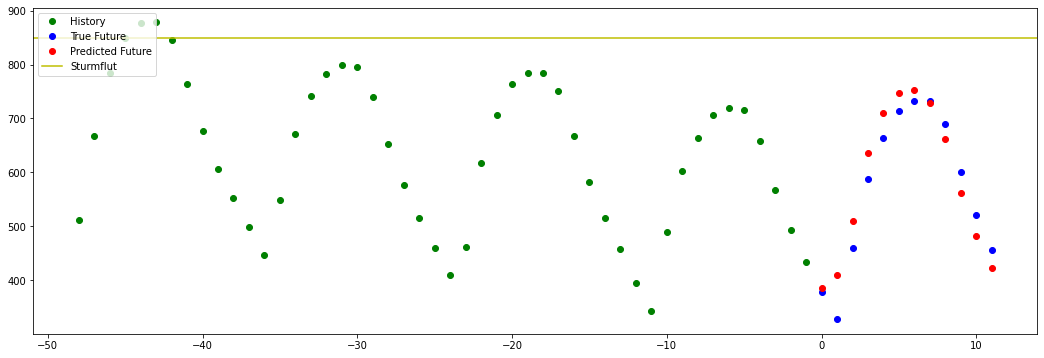

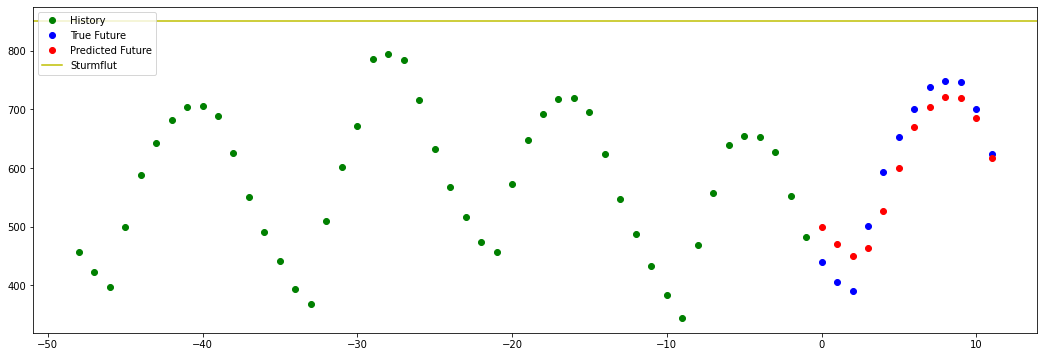

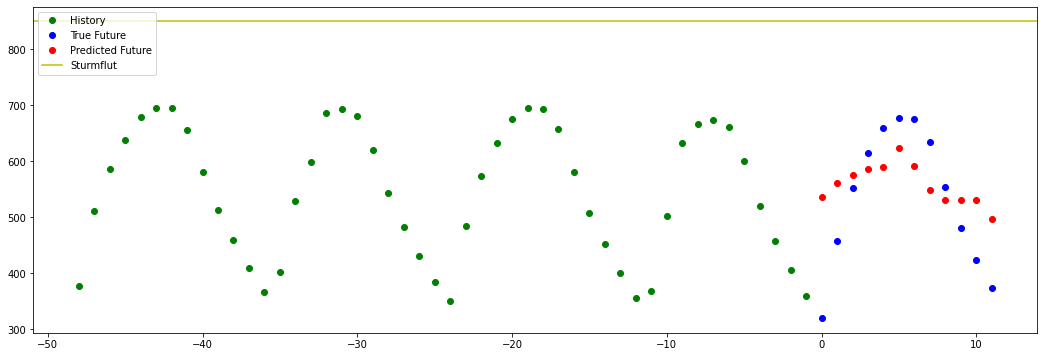

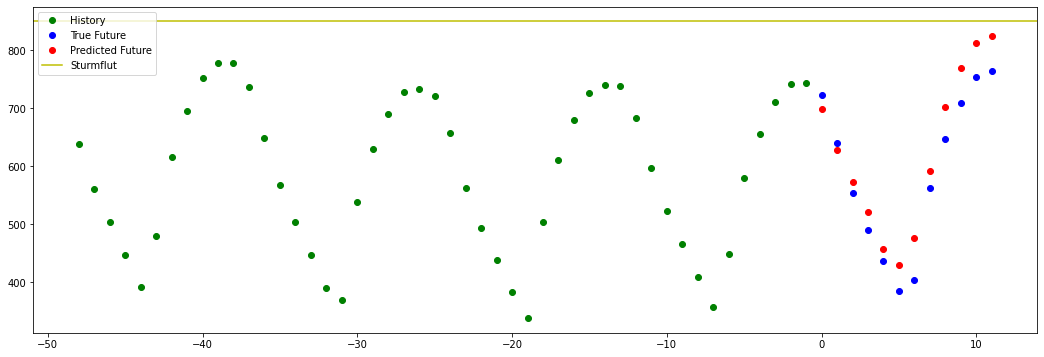

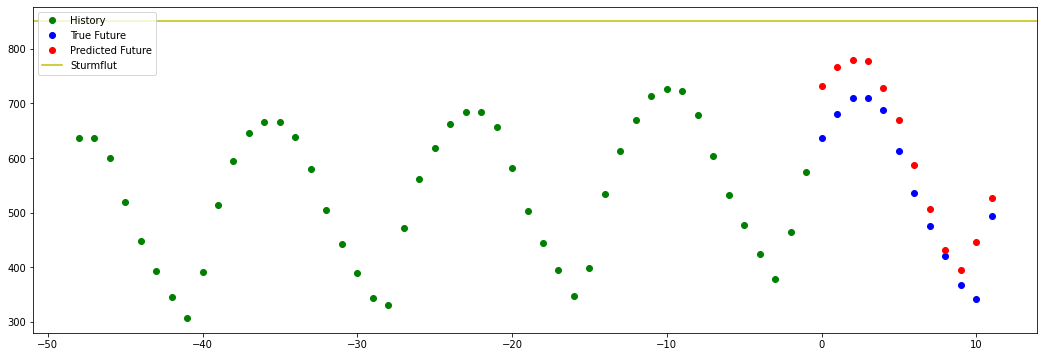

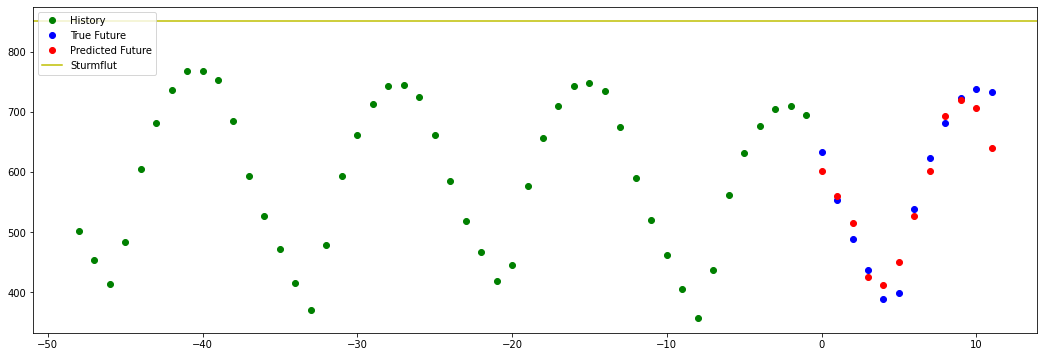

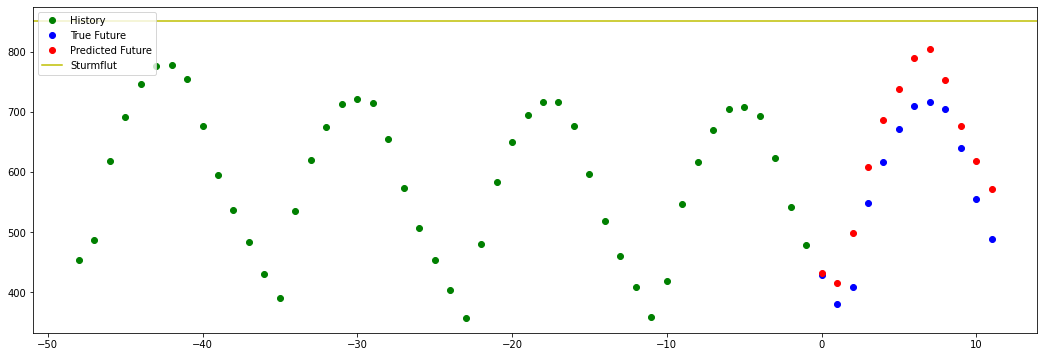

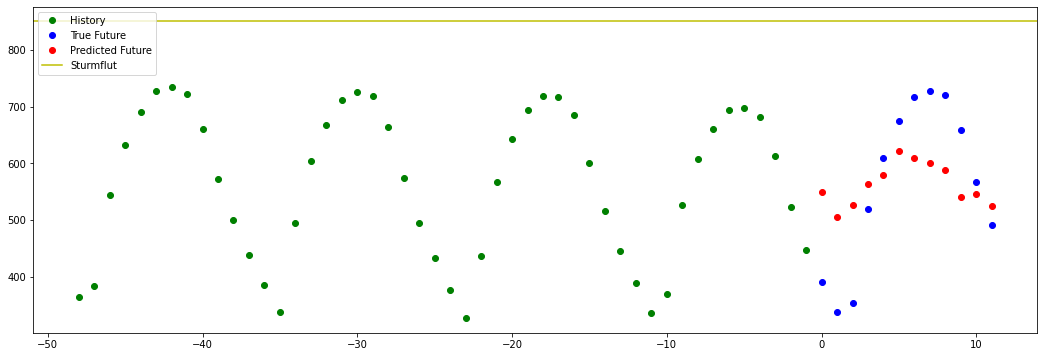

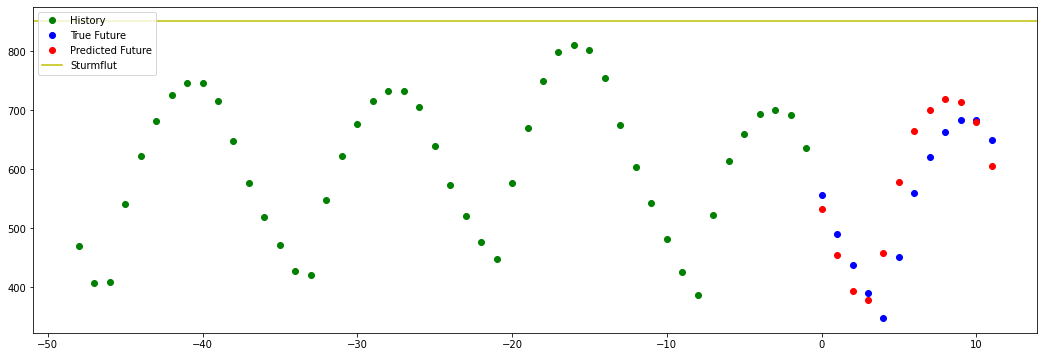

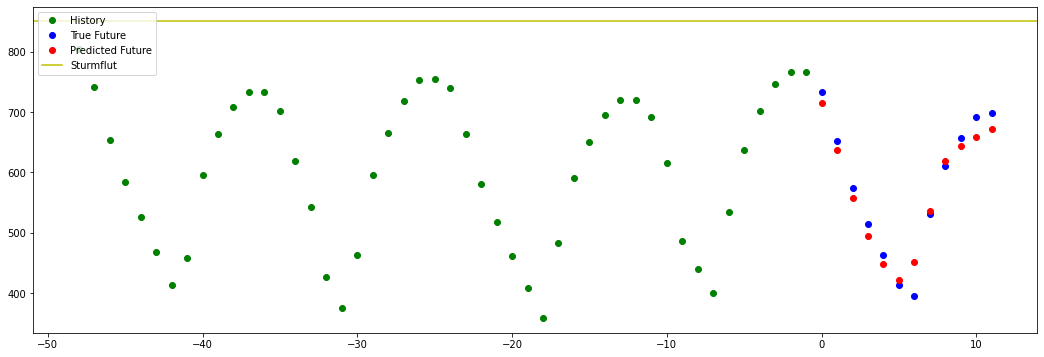

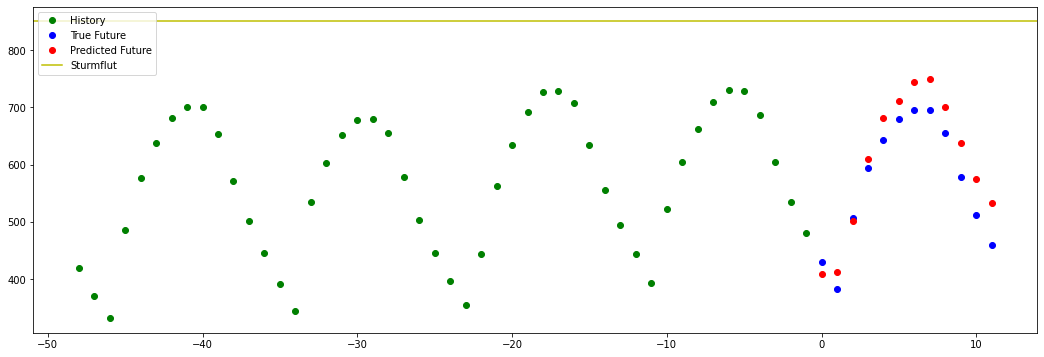

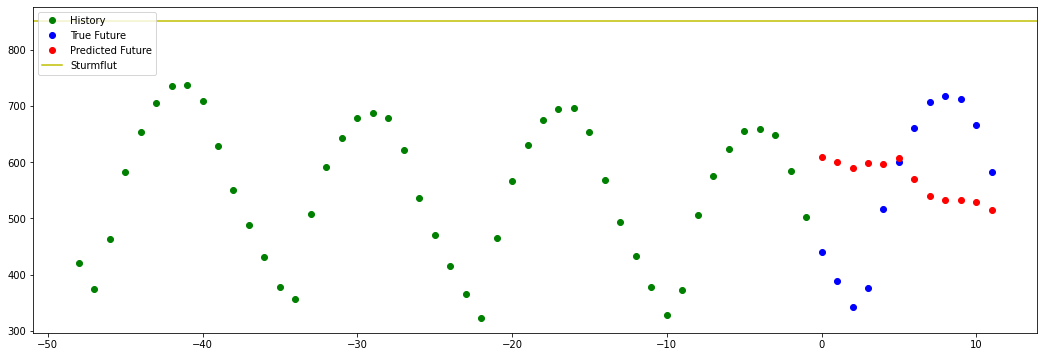

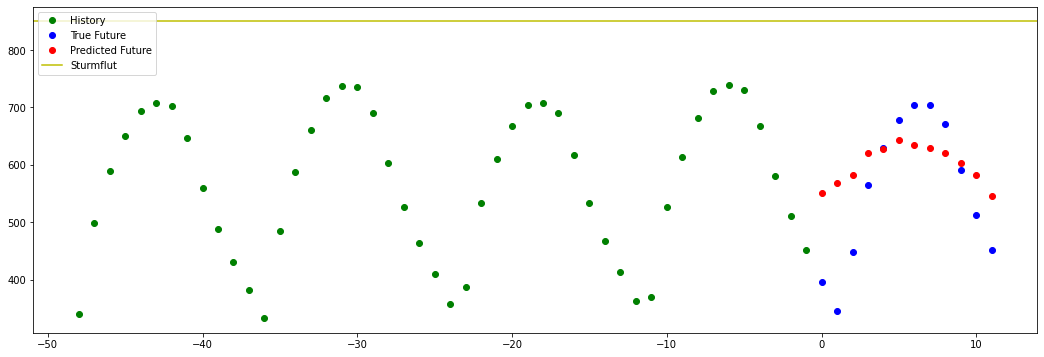

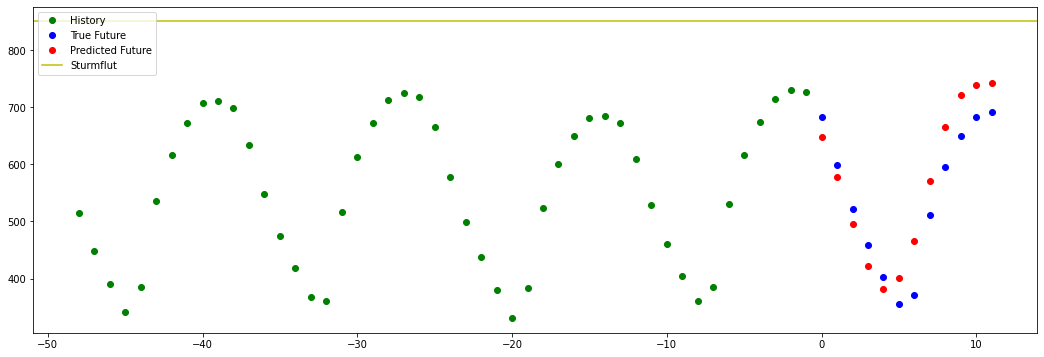

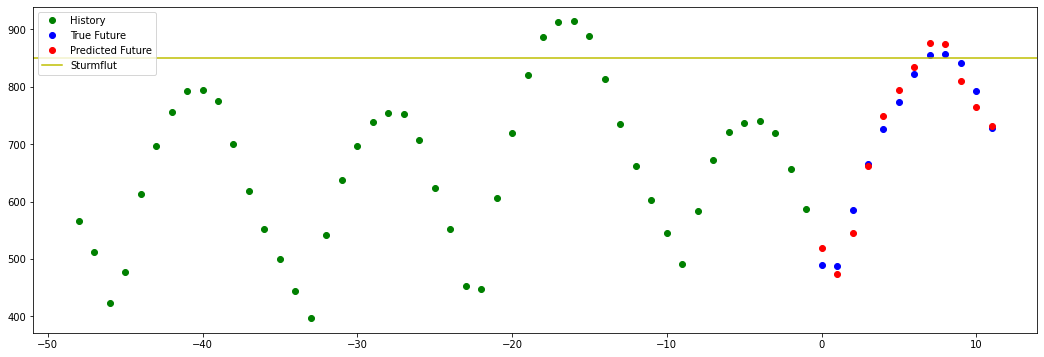

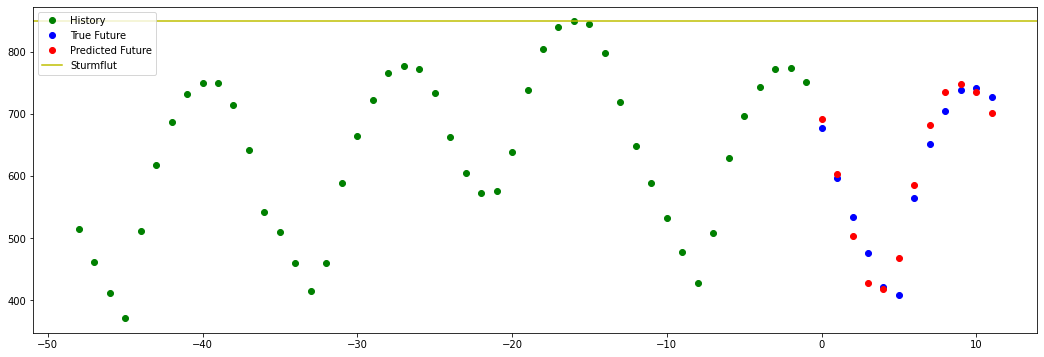

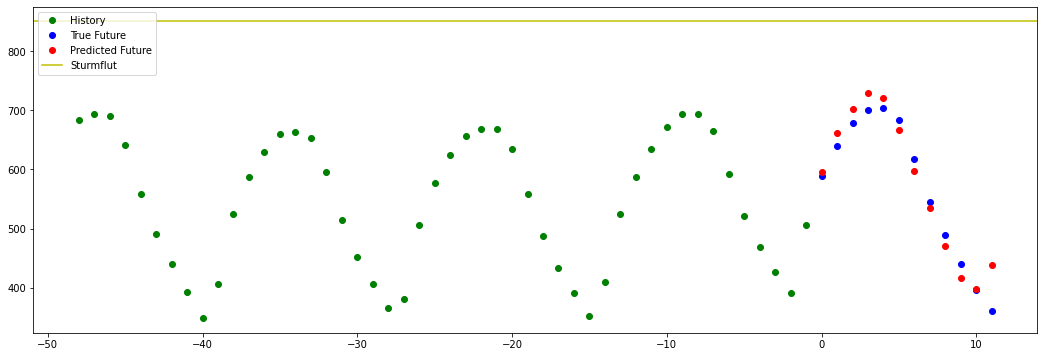

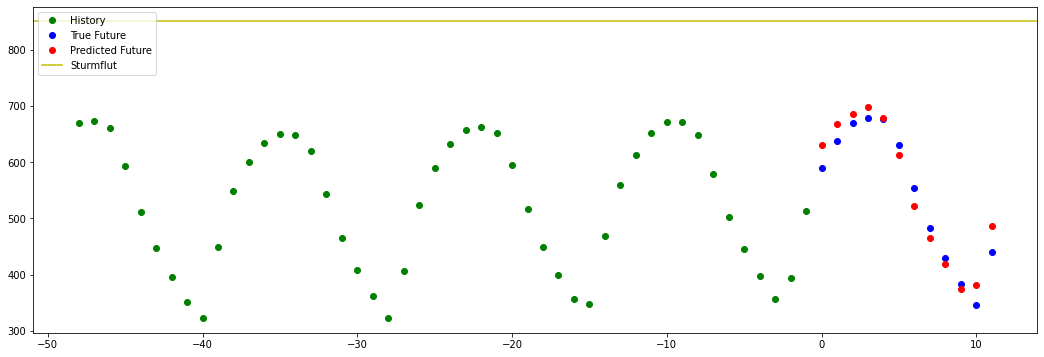

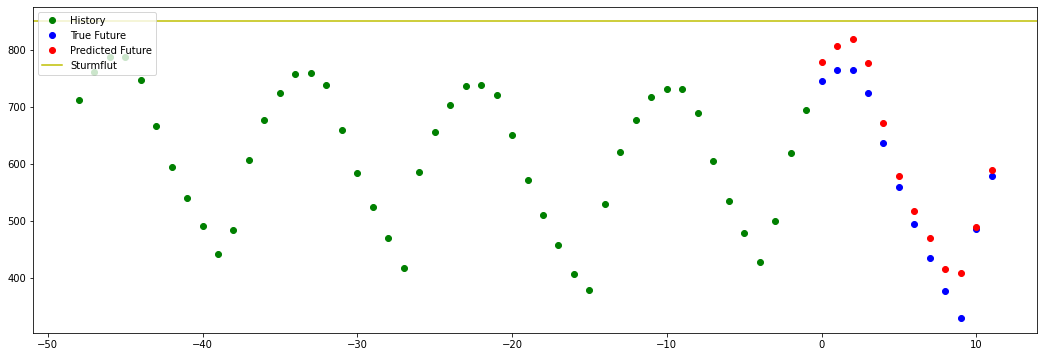

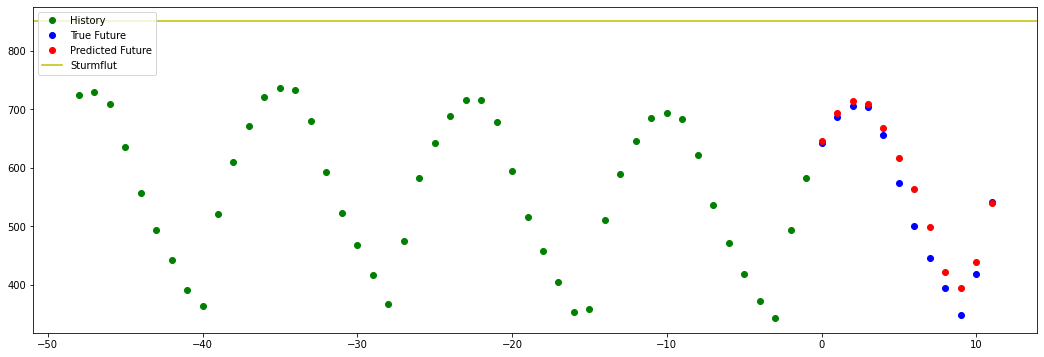

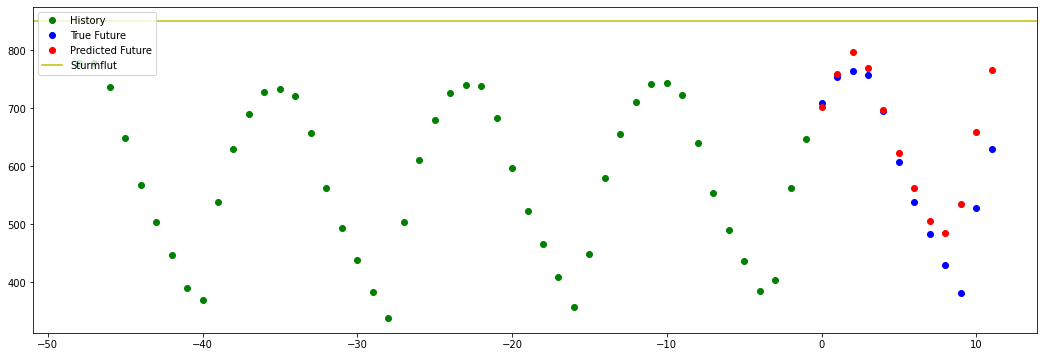

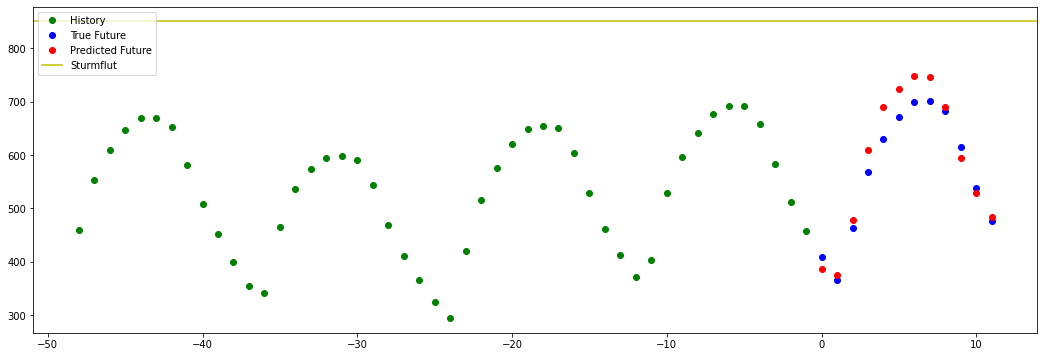

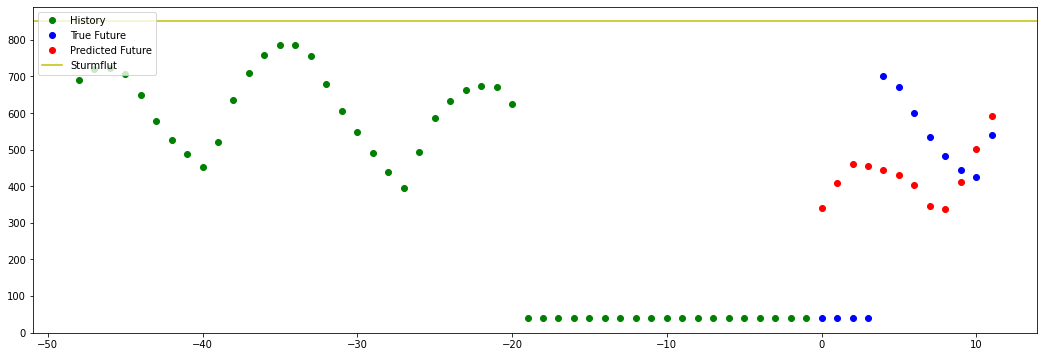

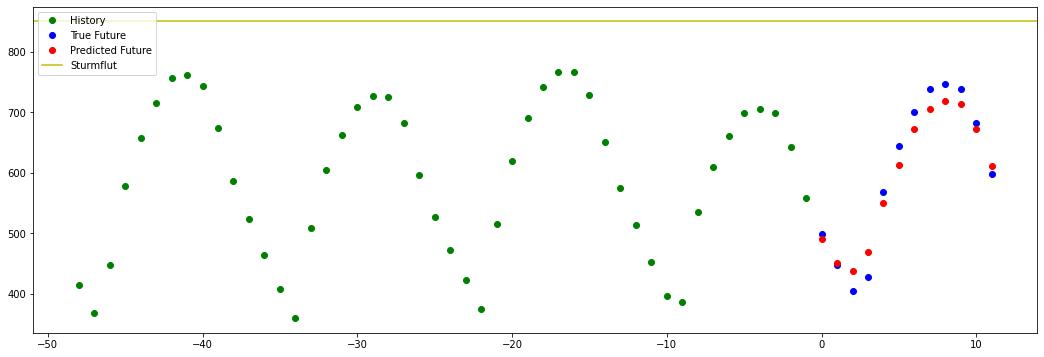

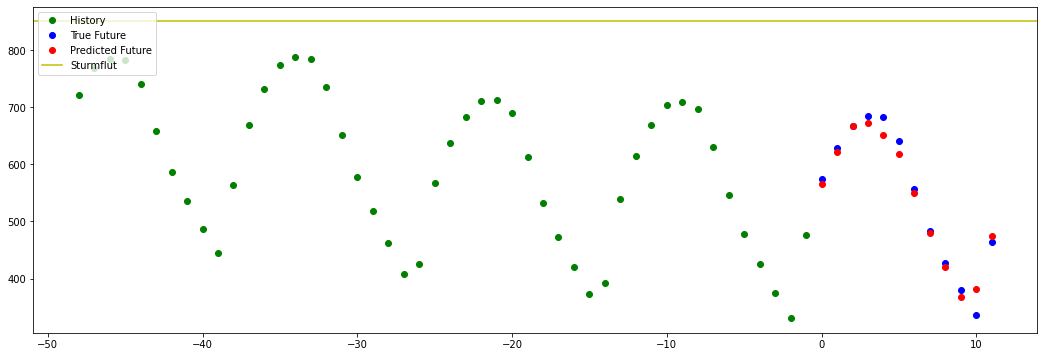

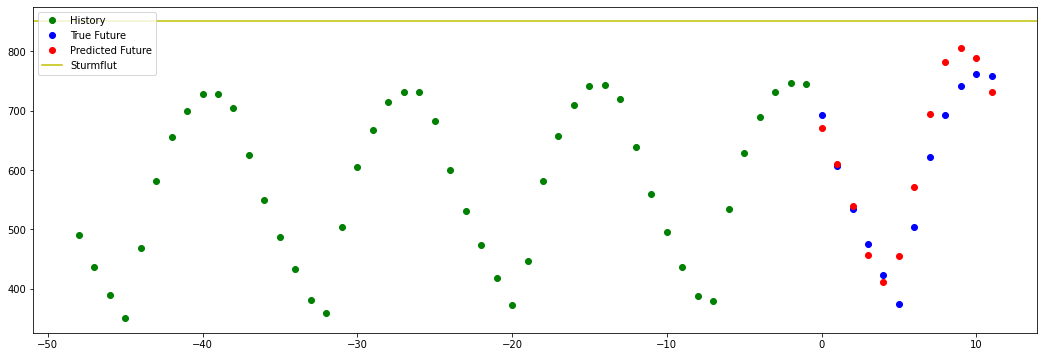

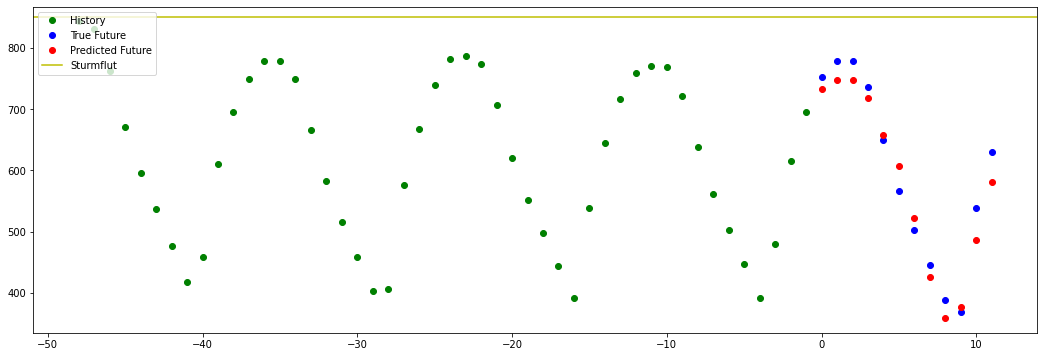

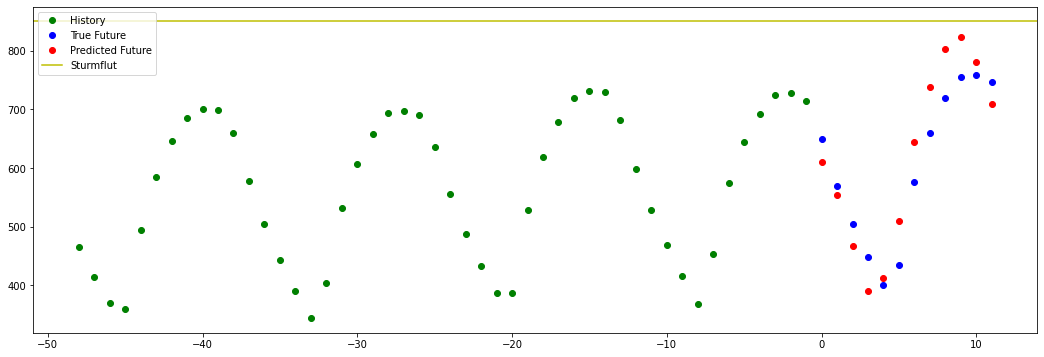

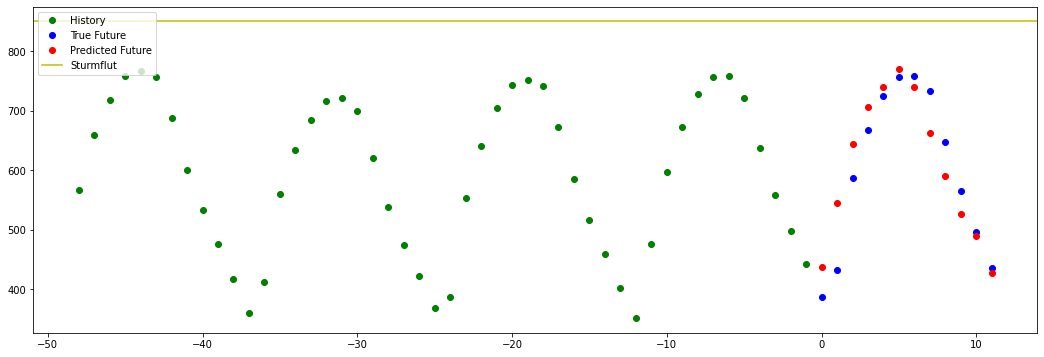

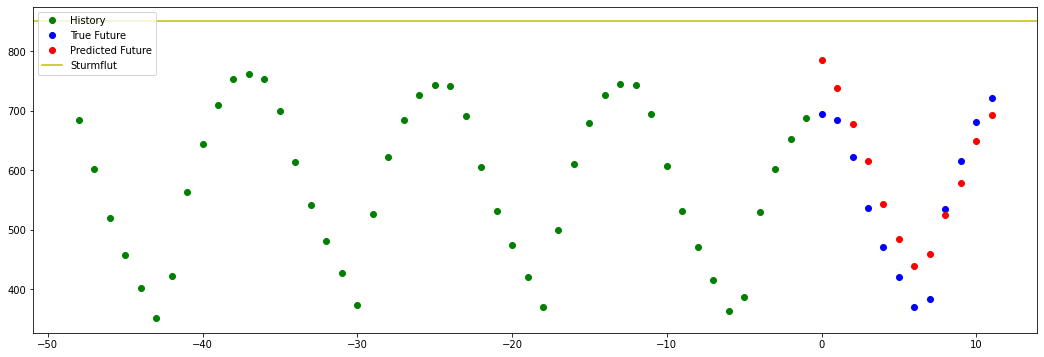

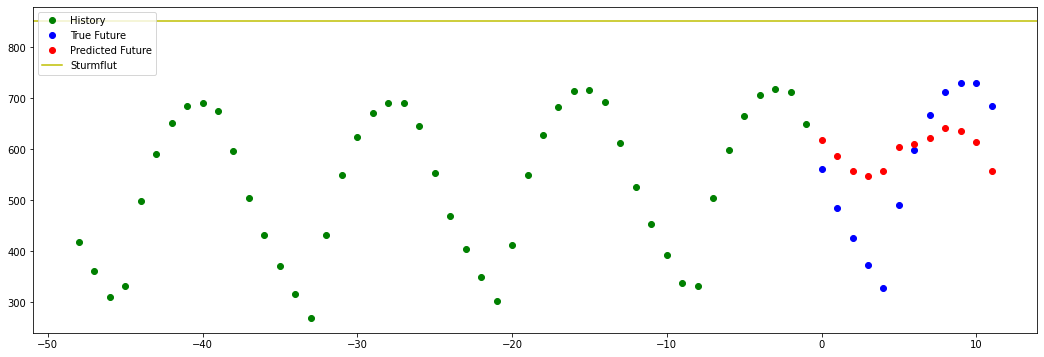

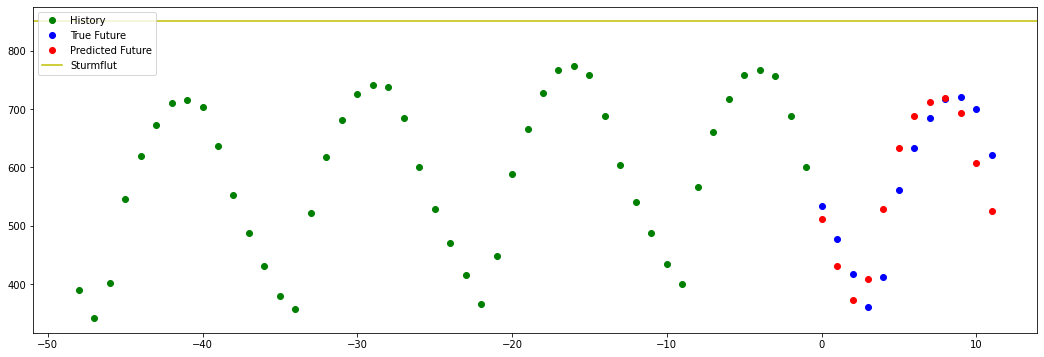

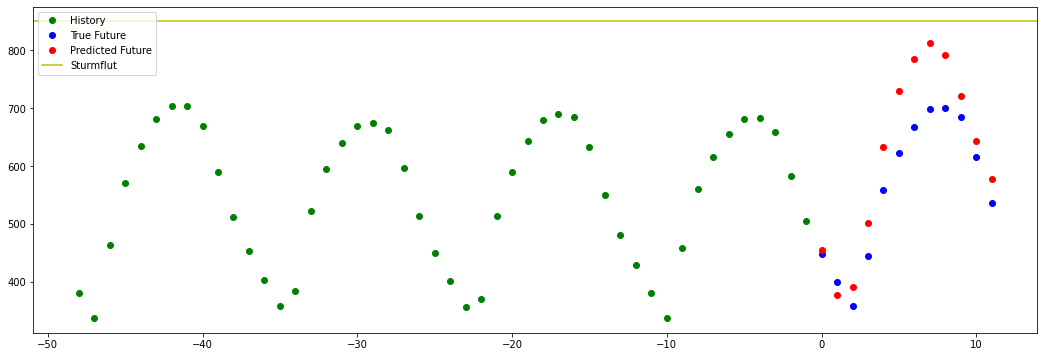

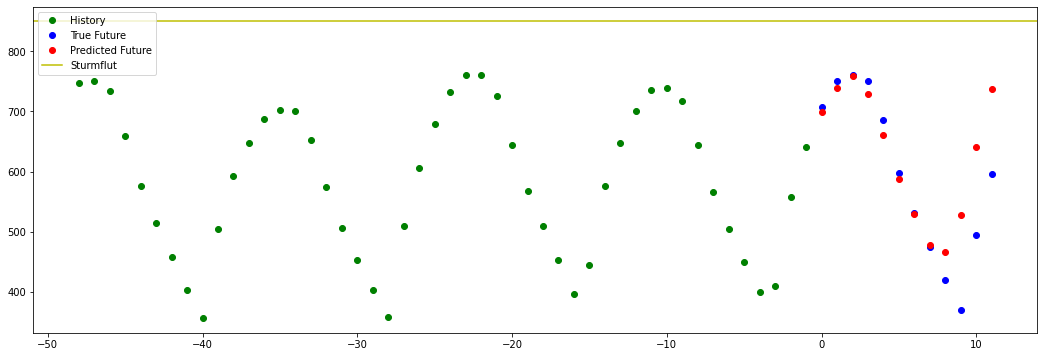

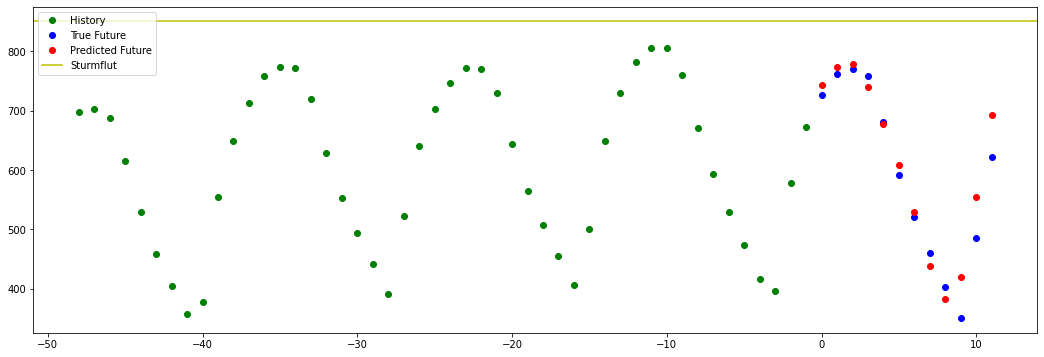

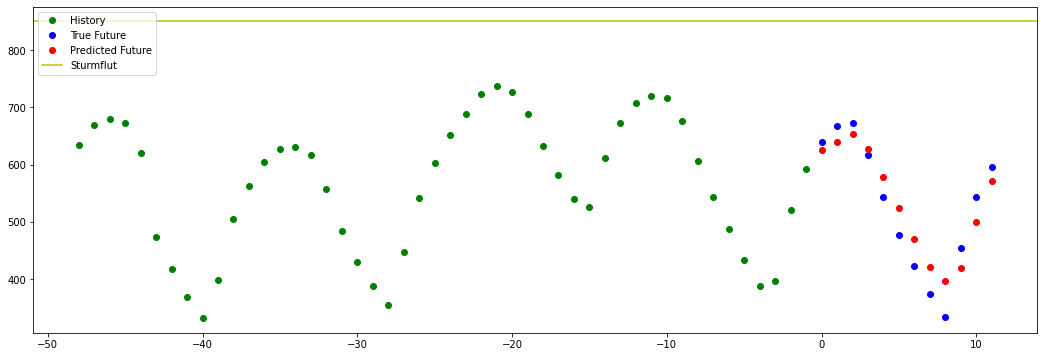

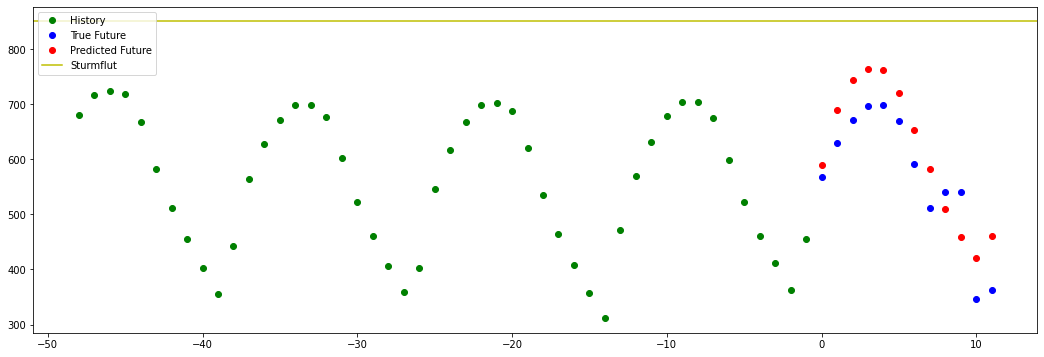

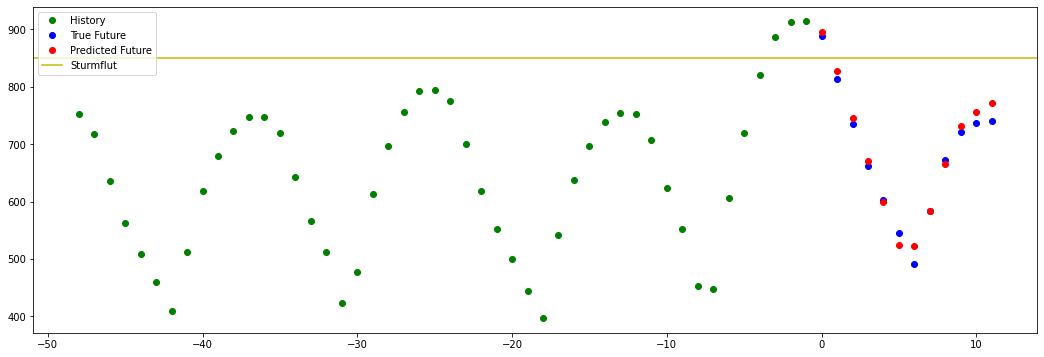

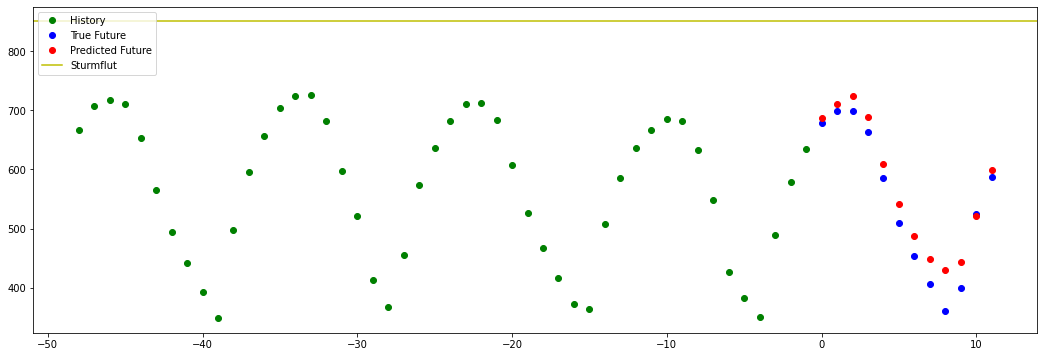

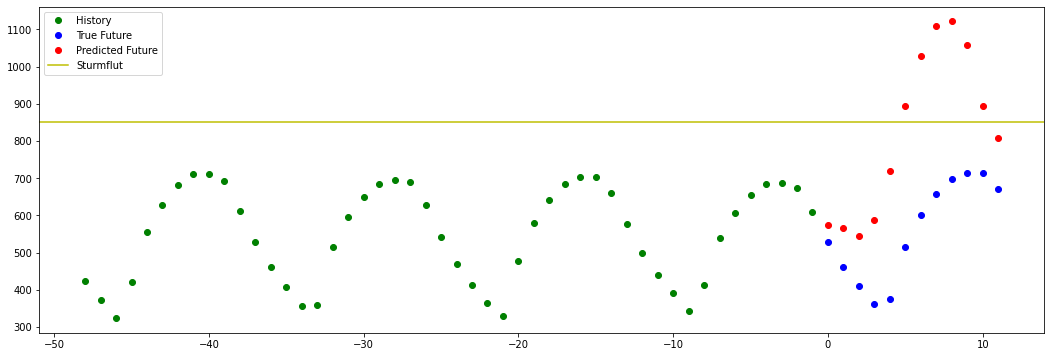

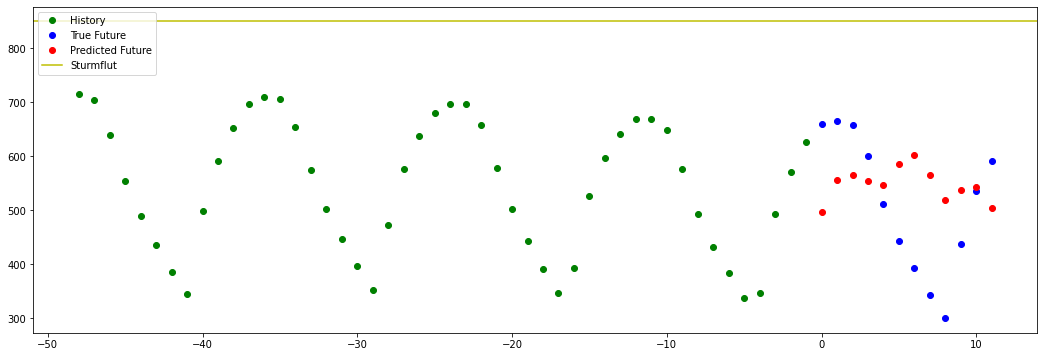

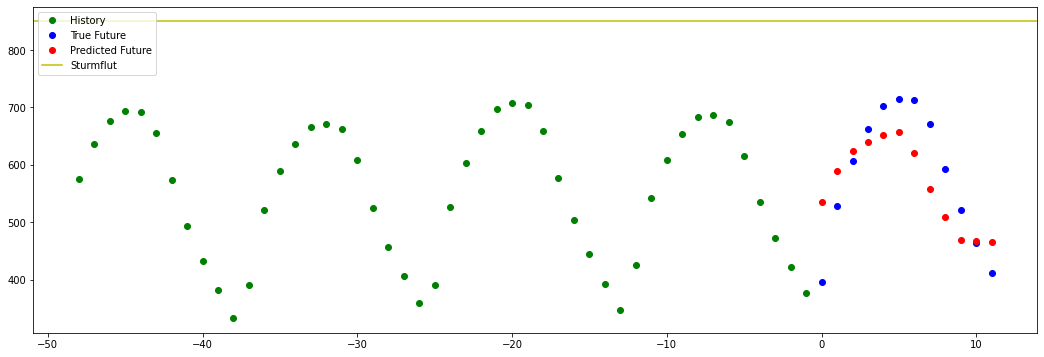

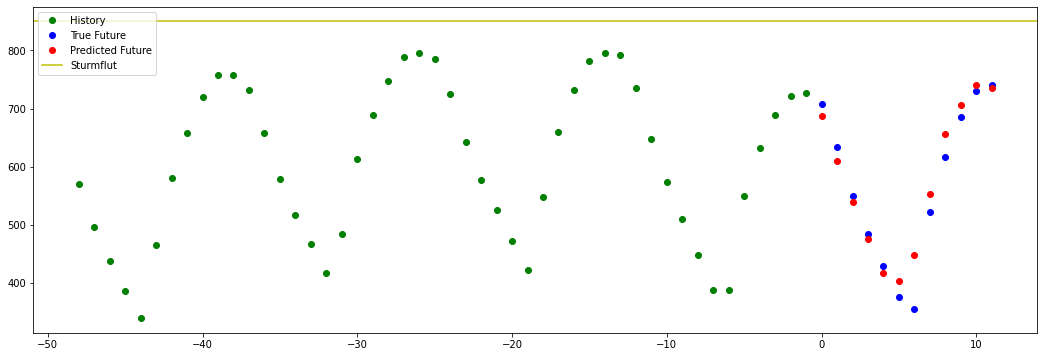

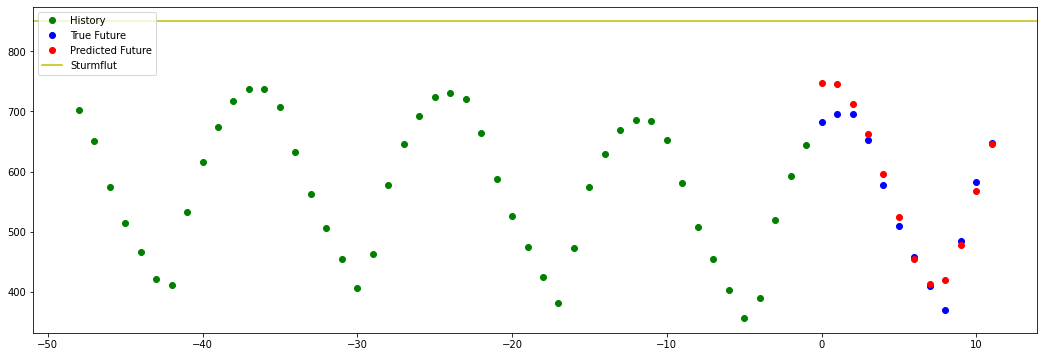

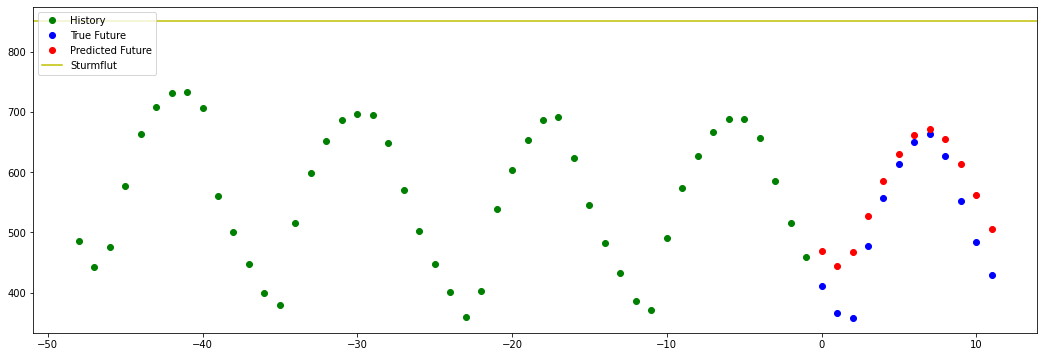

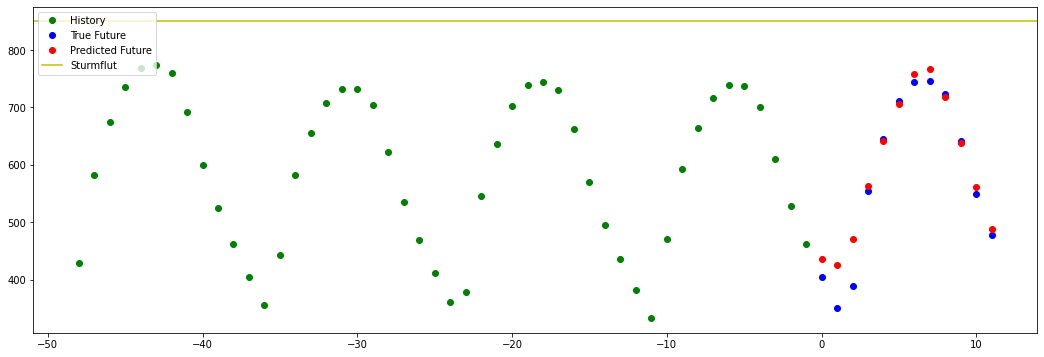

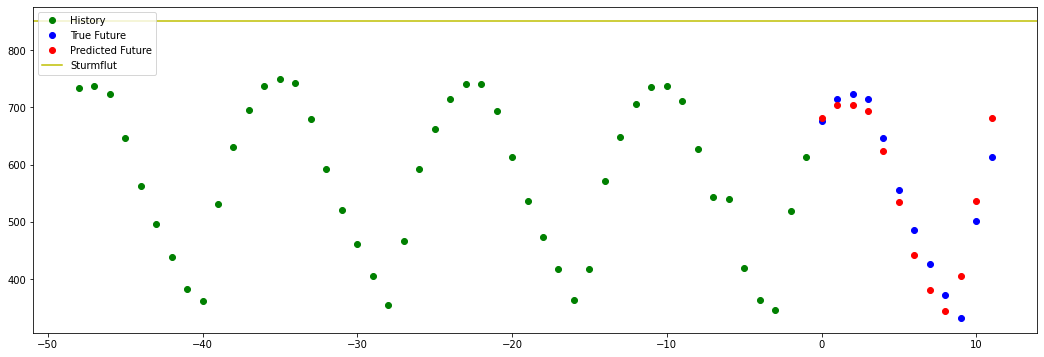

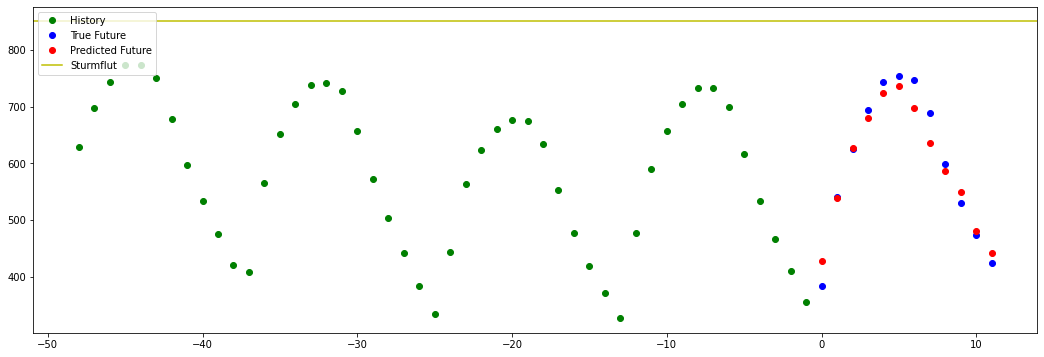

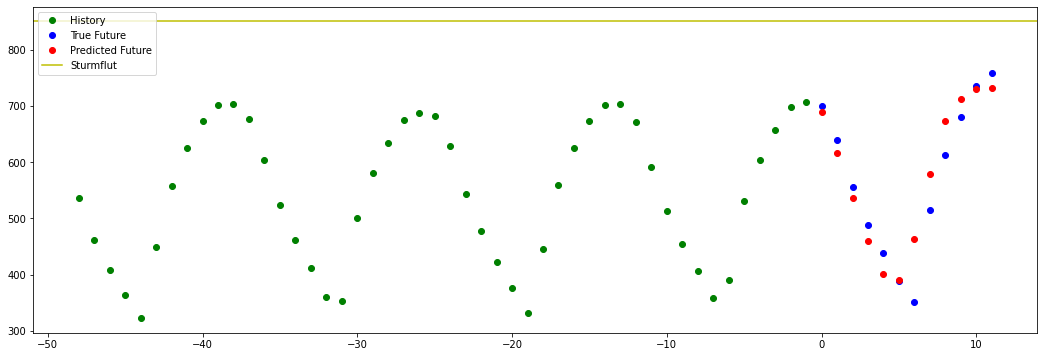

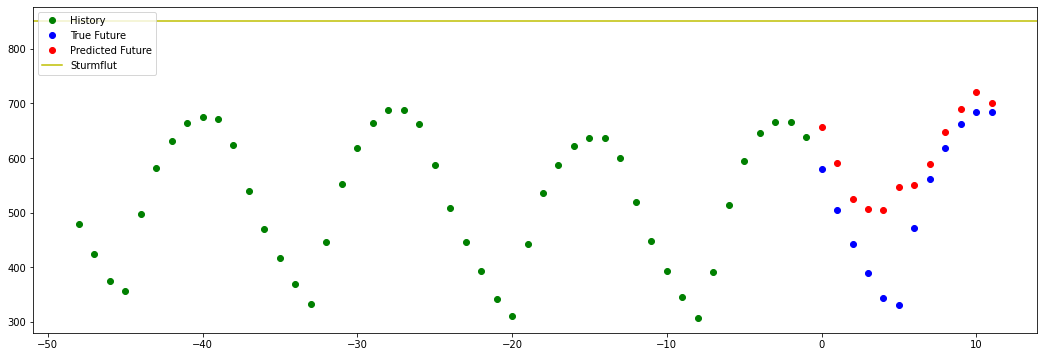

In [ ]:
for x, y in val_dataset.take(50):
    multi_step_plot(x[0,:,0], y[0], model_one_mse_balanced.predict(x)[0])

#### Two Layer LSTM

In [ ]:
model_mse_balanced = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_mse_balanced.keras',
                                     save_best_only=True)
]

model_mse_balanced.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_mse_balanced = model_mse_balanced.fit(balanced_train_dataset,
                    epochs=10,
                    validation_data=balanced_val_dataset,
                    callbacks=callbacks)

Epoch 1/10
488/488 [==============================] - 23s 41ms/step - loss: 0.7741 - mae: 0.6411 - root_mean_squared_error: 0.8798 - val_loss: 0.3936 - val_mae: 0.4908 - val_root_mean_squared_error: 0.6273
Epoch 2/10
488/488 [==============================] - 20s 40ms/step - loss: 0.2665 - mae: 0.3341 - root_mean_squared_error: 0.5163 - val_loss: 0.3668 - val_mae: 0.4654 - val_root_mean_squared_error: 0.6056
Epoch 3/10
488/488 [==============================] - 19s 39ms/step - loss: 0.1846 - mae: 0.2773 - root_mean_squared_error: 0.4296 - val_loss: 0.4261 - val_mae: 0.4947 - val_root_mean_squared_error: 0.6528
Epoch 4/10
488/488 [==============================] - 19s 40ms/step - loss: 0.1431 - mae: 0.2456 - root_mean_squared_error: 0.3783 - val_loss: 0.3703 - val_mae: 0.4612 - val_root_mean_squared_error: 0.6085
Epoch 5/10
488/488 [==============================] - 21s 43ms/step - loss: 0.1130 - mae: 0.2161 - root_mean_squared_error: 0.3362 - val_loss: 0.3837 - val_mae: 0.4667 - val_ro

In [ ]:
balanced_train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 24), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

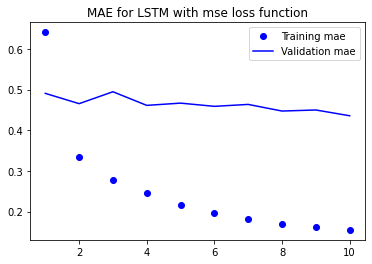

In [ ]:
loss_mse_balanced = history_mse_balanced.history['mae']
val_loss_mse_balanced = history_mse_balanced.history['val_mae']
epochs = range(1, len(loss_mse_balanced)+1)
plt.figure()
plt.plot(epochs, loss_mse_balanced, 'bo', label='Training mae')
plt.plot(epochs, val_loss_mse_balanced, 'b', label='Validation mae')
plt.title('MAE for LSTM with mse loss function')
plt.legend()
plt.show()

In [ ]:
# Check if problem with dataset: 
# it might be that in the balanced train data test data of the unbalanced it
model_mse_balanced.evaluate(test_dataset)

107/107 [==============================] - 4s 27ms/step - loss: 0.7022 - mae: 0.6129 - root_mean_squared_error: 0.8380


[0.7021834254264832, 0.6129241585731506, 0.8379637598991394]

### Custom Loss Function

#### One Layer LSTM 

In [ ]:
model_one_custom_balanced = keras.Model(inputs_one, outputs_one)

callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_custom_one_balanced.keras',
                                     save_best_only=True)
]

model_one_custom_balanced.compile(optimizer='adam', loss=custom_mse_loss, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_one_custom = model_one_custom_balanced.fit(balanced_train_dataset,
                    epochs=2,
                    validation_data=balanced_val_dataset,
                    callbacks=callbacks)

Epoch 1/2
219/488 [============>.................] - ETA: 5s - loss: 188.9914 - mae: 0.2140 - root_mean_squared_error: 0.3646

KeyboardInterrupt: ignored

In [ ]:
for x, y in val_dataset.take(50):
    multi_step_plot_compare(x[0,:,0], y[0], model_one_custom_balanced.predict(x)[0], model_one_custom_balanced.predict(x)[0], label1='CUSTOM', label2='MSE')

#### Two Layer LSTM

In [ ]:
model_custom_loss_balanced = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('st_pauli_lstm_balanced.keras',
                                     save_best_only=True)
]

model_custom_loss_balanced.compile(optimizer='adam', loss=custom_mse_loss, metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

history_custom_balanced = model_custom_loss_balanced.fit(balanced_train_dataset,
                    epochs=2,
                    validation_data=balanced_val_dataset,
                    callbacks=callbacks)

In [ ]:
loss_custom_balanced = history_custom_balanced.history['mae']
val_loss_custom_balanced = history_custom.history['val_mae']
epochs = range(1, len(loss_custom)+1)
plt.figure()
plt.plot(epochs, loss_custom_balanced, 'bo', label='Training mae')
plt.plot(epochs, val_loss_custom_balanced, 'b', label='Validation mae')
plt.title('MAE for LSTM with custom loss function')
plt.legend()
plt.show()

## Evaluation
In the evaluation we will test if the different LSTM models can predict floods. We will use a restriced dataset consisting of 48-hours before a flood occuring in an 12-hour interval. Therefore a perfect model would predict a flood for each input. Note that we cut a hard-line between a flood occuring and no flood occuring.

In [ ]:
x_train_flood_12, x_val_flood_12, x_test_flood_12 = [],[],[]
y_train_flood_12, y_val_flood_12, y_test_flood_12 = [],[],[]

for index in flood_indeces[:num_train_samples_flood]:
    for offset in range(12):
        x_train_flood_12.append(stpauli_hourly_flood[index-59+offset:index-11+offset])
        y_train_flood_12.append(stpauli_hourly_flood.iloc[index-11+offset:index+1+offset,0])

for index in flood_indeces[num_train_samples_flood:num_train_samples_flood+num_val_samples_flood]:
    for offset in range(12):
        x_val_flood_12.append(stpauli_hourly_flood[index-59+offset:index-11+offset])
        y_val_flood_12.append(stpauli_hourly_flood.iloc[index-11+offset:index+1+offset,0])
    

for index in flood_indeces[num_train_samples_flood+num_val_samples_flood:]:
    for offset in range(12):
        x_test_flood_12.append(stpauli_hourly_flood[index-59+offset:index-11+offset])
        y_test_flood_12.append(stpauli_hourly_flood.iloc[index-11+offset:index+1+offset,0])
    

x_train_flood_12 = np.asarray(x_train_flood_12)
x_val_flood_12 = np.asarray(x_val_flood_12)
x_test_flood_12 = np.asarray(x_test_flood_12)

y_train_flood_12 = np.asarray(y_train_flood_12)
y_val_flood_12 = np.asarray(y_val_flood_12)
y_test_flood_12 = np.asarray(y_test_flood_12)

In [ ]:
print("A perfect model would predict ", x_test_flood_12.shape[0]," floods.")

A perfect model would predict  456  floods.


In [ ]:
(850 - mean[0]) / std[0]

2.266016121070689

In [ ]:
# Function to check if a flood got predicted
def detect_flood(y_pred):
    detected_floods = 0
    for i in range(y_pred.shape[0]):
      floods = []
      floods = y_pred[i] >= 2.266
      if floods.any():
        detected_floods += 1
    

    return detected_floods

In [ ]:
# Model predictions

y_pred_ar_custom = model_ar_custom.predict(x_test_flood_12)
y_pred_ar_mse = model_ar_mse.predict(x_test_flood_12)
y_pred_lstm_mse = stpauli_lstm_mse.predict(x_test_flood_12)
y_pred_lstm_custom = stpauli_lstm_custom.predict(x_test_flood_12)
y_pred_lstm_one_custom = stpauli_lstm_one_custom.predict(x_test_flood_12)
y_pred_lstm_one_mse = stpauli_lstm_one_mse.predict(x_test_flood_12)

In [ ]:
num_floods = [x_test_flood_12.shape[0],detect_flood(y_pred_lstm_one_mse),detect_flood(y_pred_lstm_one_custom), detect_flood(y_pred_lstm_mse),detect_flood(y_pred_lstm_custom), detect_flood(y_pred_ar_mse), detect_flood(y_pred_ar_custom)]
names = ['Actual','One-Layer LSTM (MSE)', 'One-Layer LSTM (Custom)','LSTM (MSE)', 'LSTM (Custom)', 'Feedback LSTM (MSE)','Feedback LSTM (Custom)']

In [ ]:
for i,j in zip(num_floods, names):
    print(j,' : ', i, sep='')
    print(np.round(100/x_test_flood_12.shape[0] * i,2), '%')


Actual : 456
100.0 %
One-Layer LSTM (MSE) : 281
61.62 %
One-Layer LSTM (Custom) : 323
70.83 %
LSTM (MSE) : 243
53.29 %
LSTM (Custom) : 239
52.41 %
Feedback LSTM (MSE) : 58
12.72 %
Feedback LSTM (Custom) : 187
41.01 %


Text(0, 0.5, 'Number of predicted Floods')

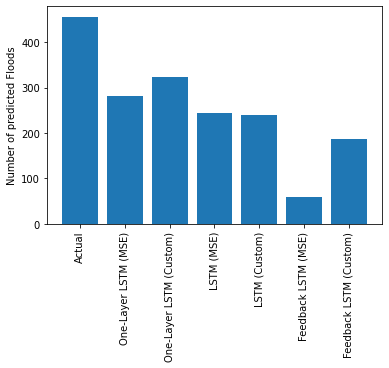

In [ ]:
fig, ax = plt.subplots()
p1 = ax.bar(names, num_floods, align='center')
plt.xticks(rotation=90)

plt.ylabel('Number of predicted Floods')